### AI_HW_13
인공지능 과제 13 - 한동민, 최동우, 최동규
1. 데이터 전처리 없는 Linear 모델
    - 원핫인코딩을 제외한 별도의 처리없이 Linear Regression 모델
2. 편향도를 보정한 Linear 모델
    - 최적화를 위해 데이터전처리 과정 (데이터의 편향도를 차트로 확인하고, Log or sqrt 로 보정.)
3. 두 모델을 비교하는 그림과 reasoning
4. Lasso 모델
5. SGD 모델


### 데이터를 받아오는 과정

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


In [2]:
train = pd.read_csv("train.csv")
beta = pd.read_csv("train.csv")
#test = pd.read_csv("test.csv")

In [3]:
print(train.shape)
train.head()


(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#원핫인코딩하는 코드
one_hot_encode_cols = beta.dtypes[beta.dtypes == object]  # filtering by string categoricals
one_hot_encode_cols = one_hot_encode_cols.index.tolist()  # list of categorical fields

for col in one_hot_encode_cols:
    beta[col] = pd.Categorical(beta[col])

# Do the one hot encoding
beta = pd.get_dummies(beta, columns=one_hot_encode_cols)

In [5]:
#결측치 처리
beta = beta.fillna(beta.mean())
print(beta.isnull().sum())

Id                       0
MSSubClass               0
LotFrontage              0
LotArea                  0
OverallQual              0
                        ..
SaleCondition_AdjLand    0
SaleCondition_Alloca     0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 290, dtype: int64


In [6]:
train, test = train_test_split(train, test_size=0.3, random_state=42)
train_beta, test_beta = train_test_split(beta, test_size=0.3, random_state=42)

In [7]:
print(train_beta.shape)
_y = train_beta["SalePrice"]
print(_y.shape)
train_beta = train_beta.drop(labels="SalePrice", axis=1)
test_y = test_beta["SalePrice"]
test_beta = test_beta.drop(labels="SalePrice", axis=1)


(1022, 290)
(1022,)


In [8]:
def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

### 원핫인코딩을 제외한 별다른 전처리 없이 Linear 모델을 학습

132086.55624266906


<AxesSubplot:xlabel='preds', ylabel='actual'>

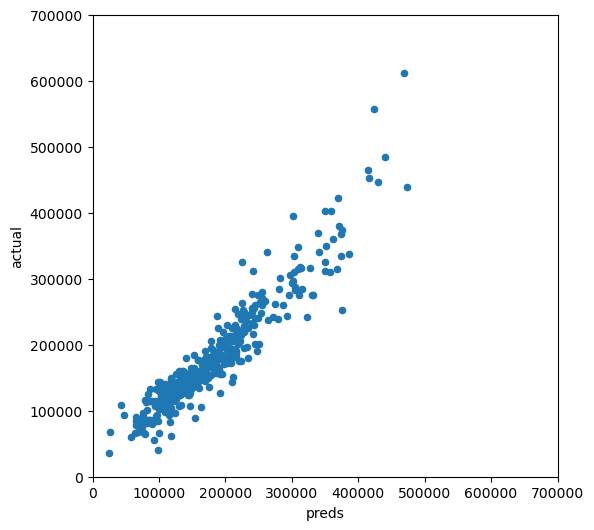

In [9]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
linearRegression_model = LinearRegression().fit(train_beta,_y)
print(rmse(linearRegression_model.predict(test_beta), test_y))
two = pd.DataFrame({"preds": linearRegression_model.predict(test_beta), "true":test_y})
two["actual"] = two["true"]

two.plot(x = "preds", y = "actual",kind = "scatter", xlim = [0, 7*1e5], ylim = [0, 7*1e5])

### 데이터 전처리 과정

In [10]:

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
print(all_data.shape)

(1460, 79)


가격에 대한 상관계수에서 Feature들의 상관계수들이 대부분 매우 낮은 것을 확인할 수 있다. 이는, intel ML 데이터와 팀의 다른 데이터와는 상반되는 모습이며, lasso 모델이 효율적으로 작동할 것으로 보인다.

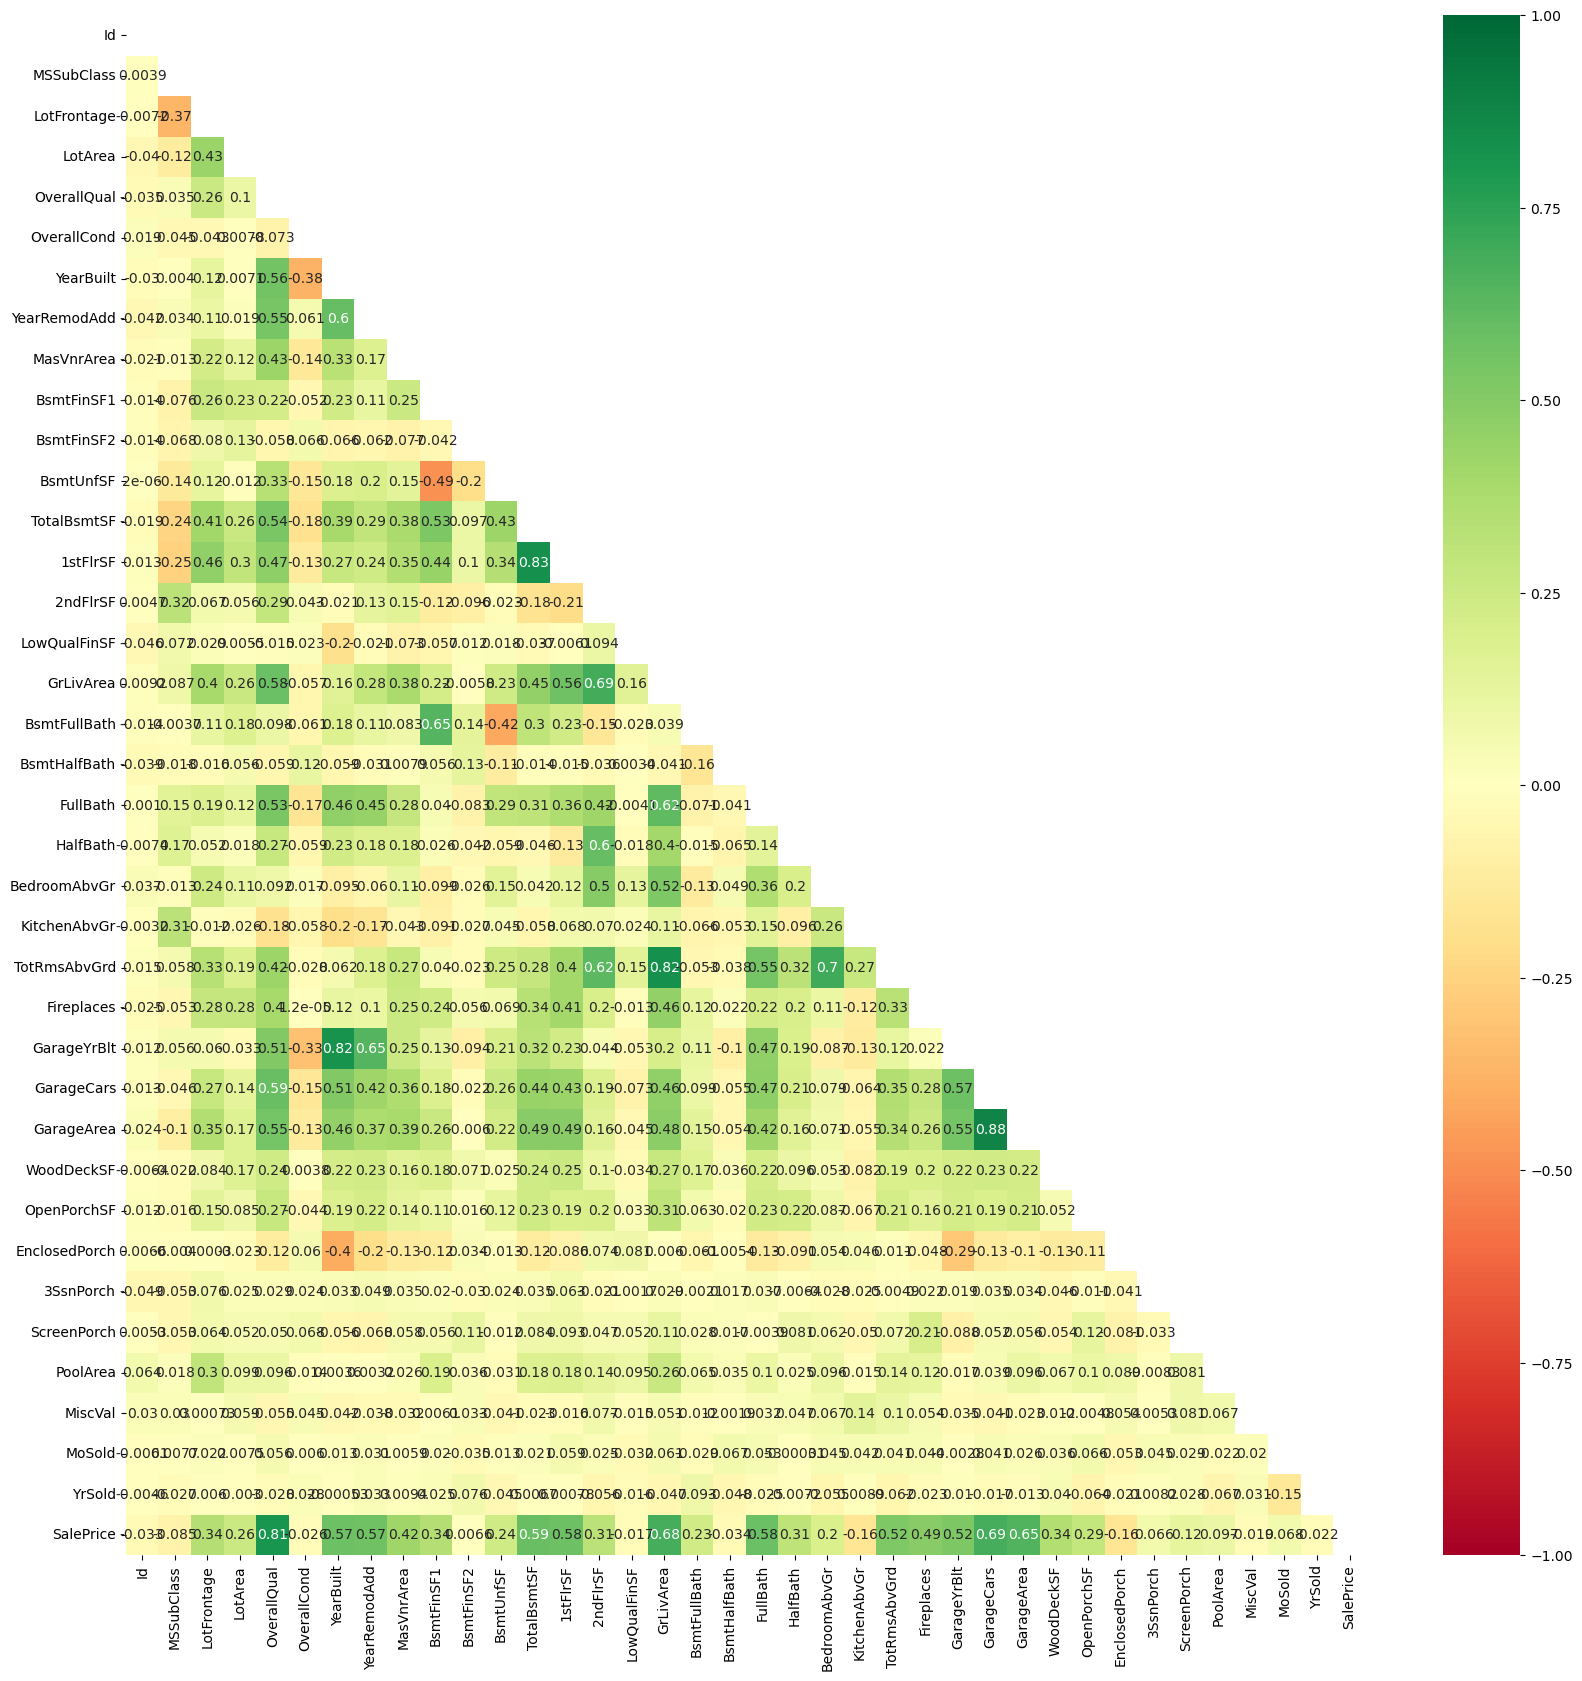

In [38]:
df = train.copy().corr()
mask = np.zeros_like(df, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (20, 20))
sns.heatmap(df,
            cmap="RdYlGn",
            mask=mask,
            annot=True,
            vmin = -1,vmax = 1
            )
plt.show()

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'log(price + 1)'}>]], dtype=object)

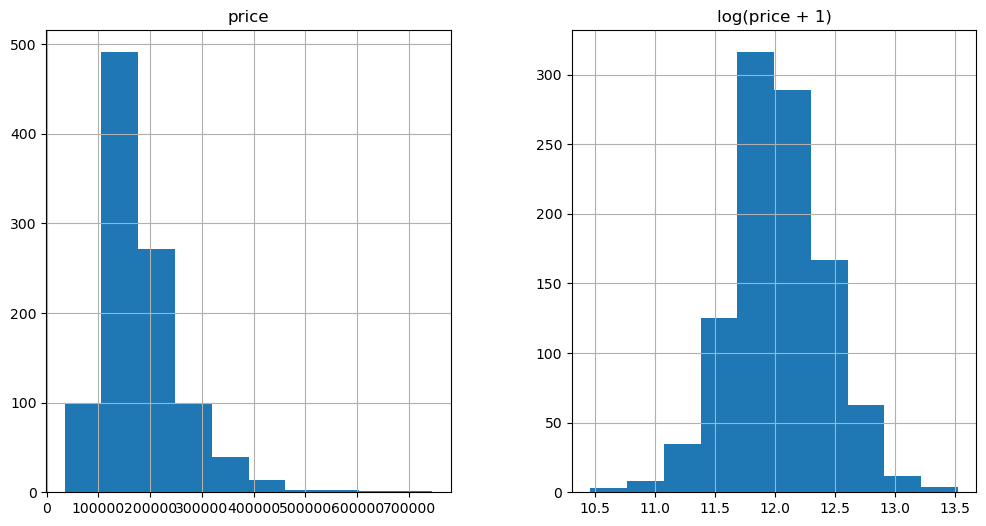

In [11]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

편향도를 확인하고, 데이터가 더 정규분포를 가지는 sqrt or log 함수를 선택함

/Users/handongmin/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:223: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


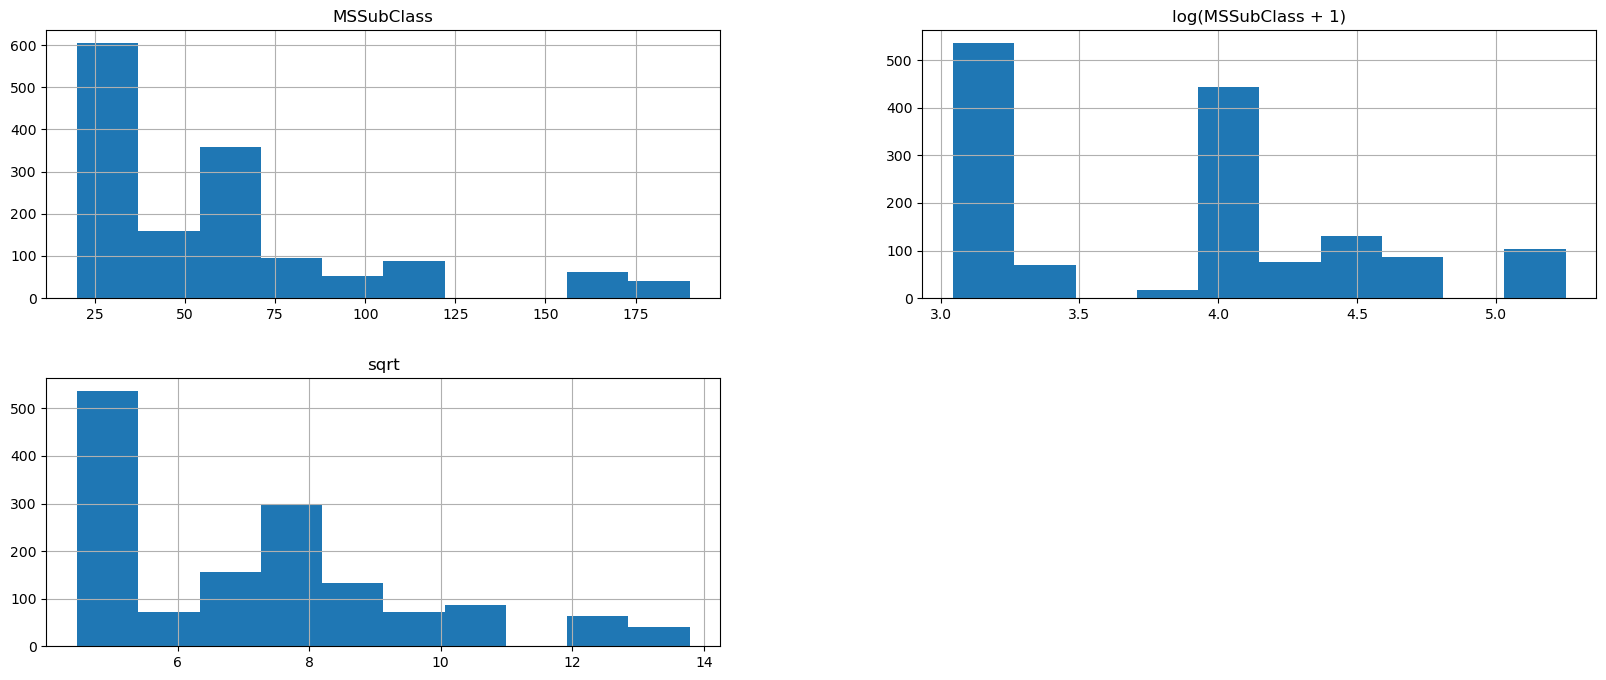

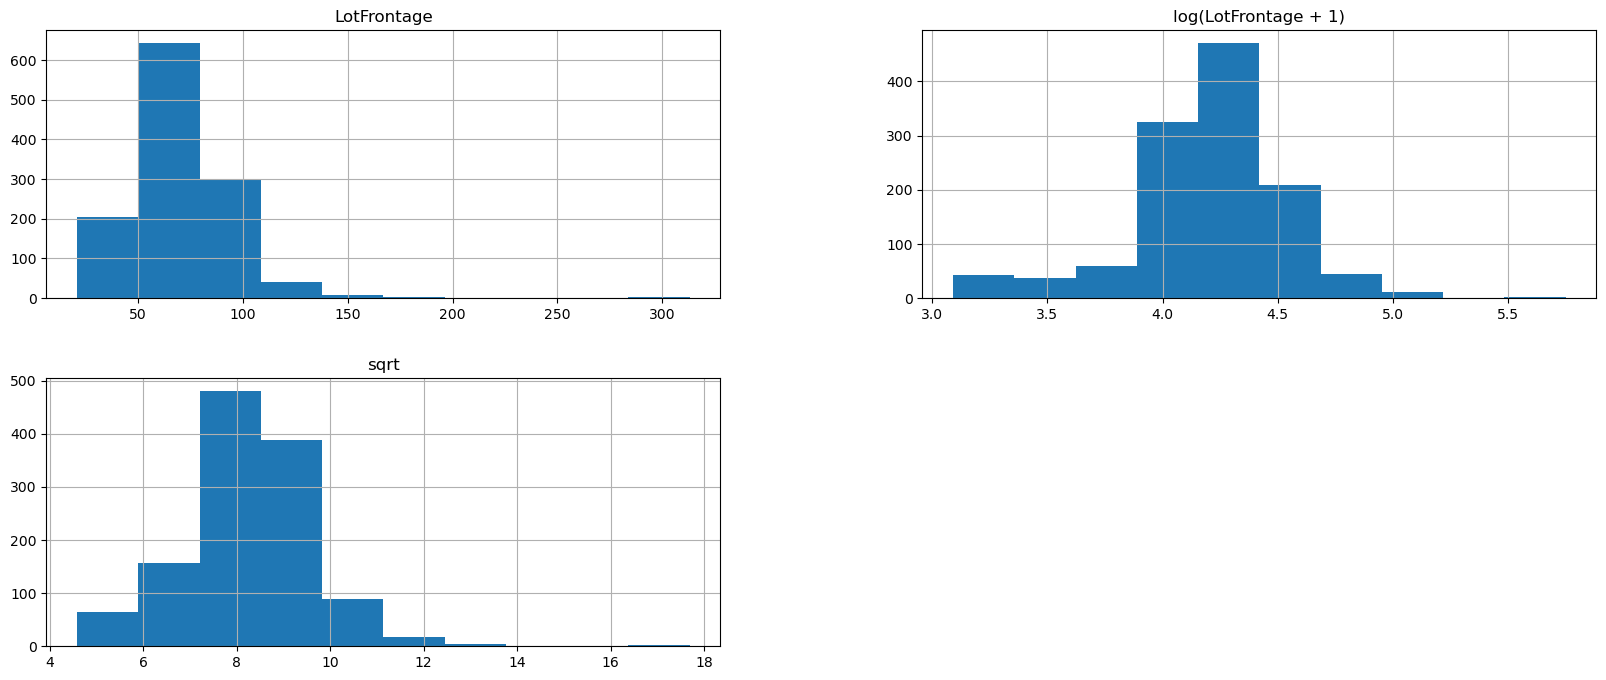

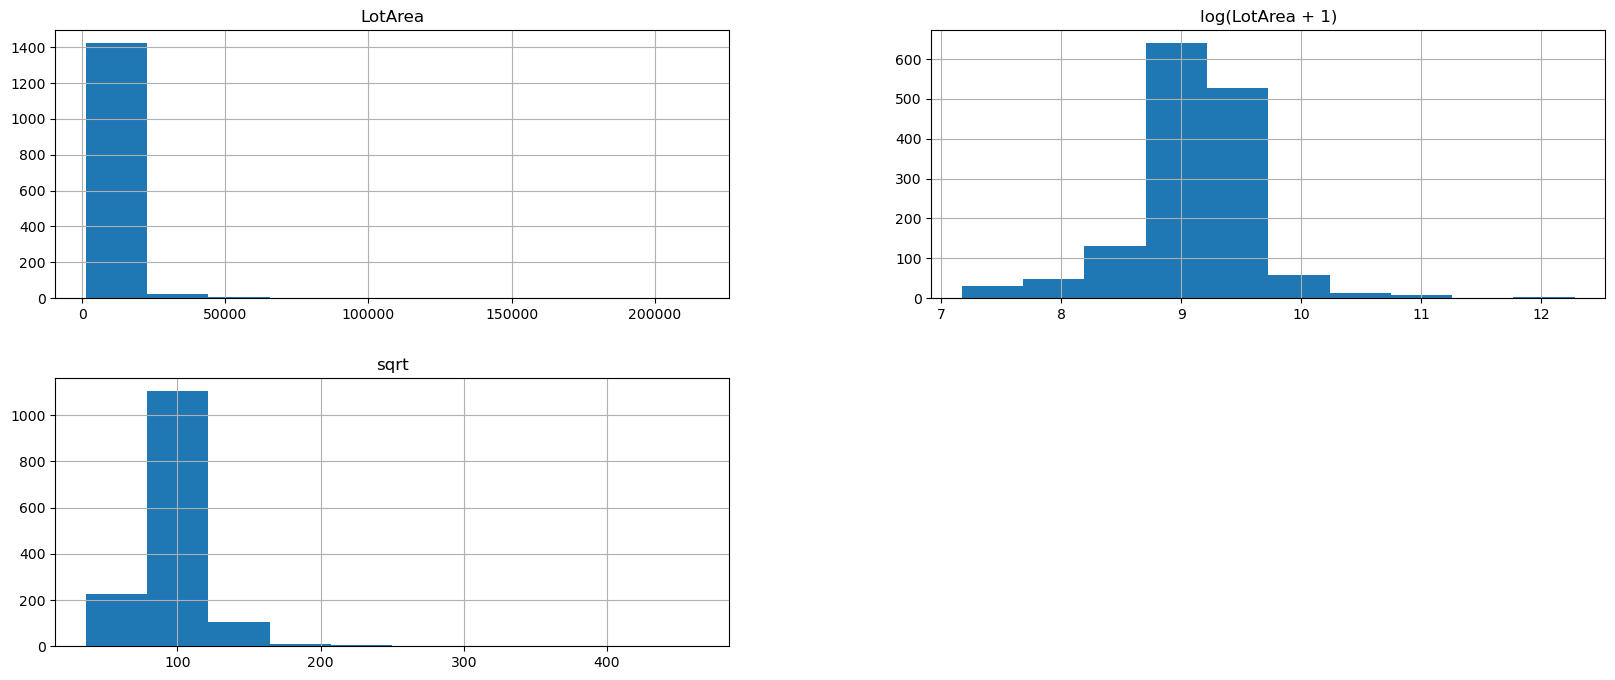

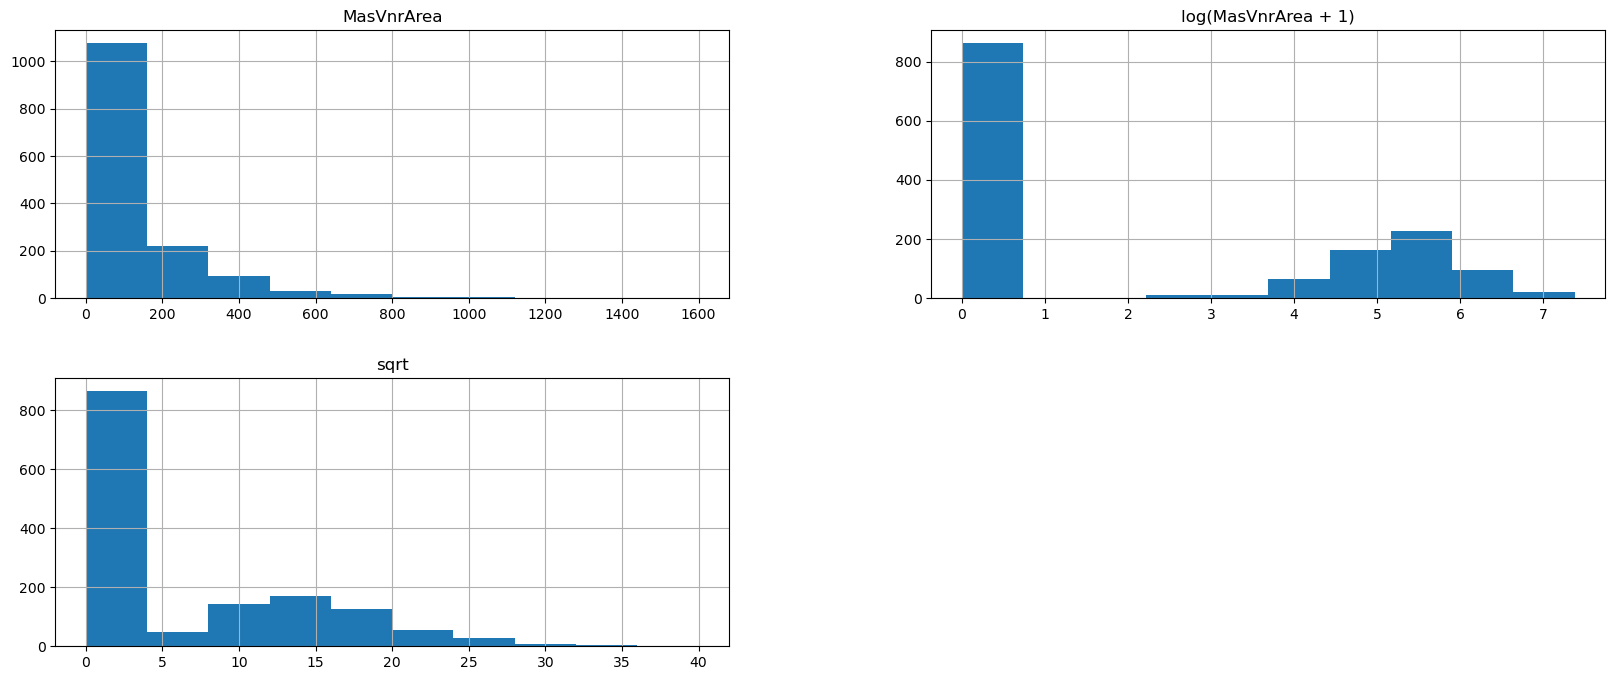

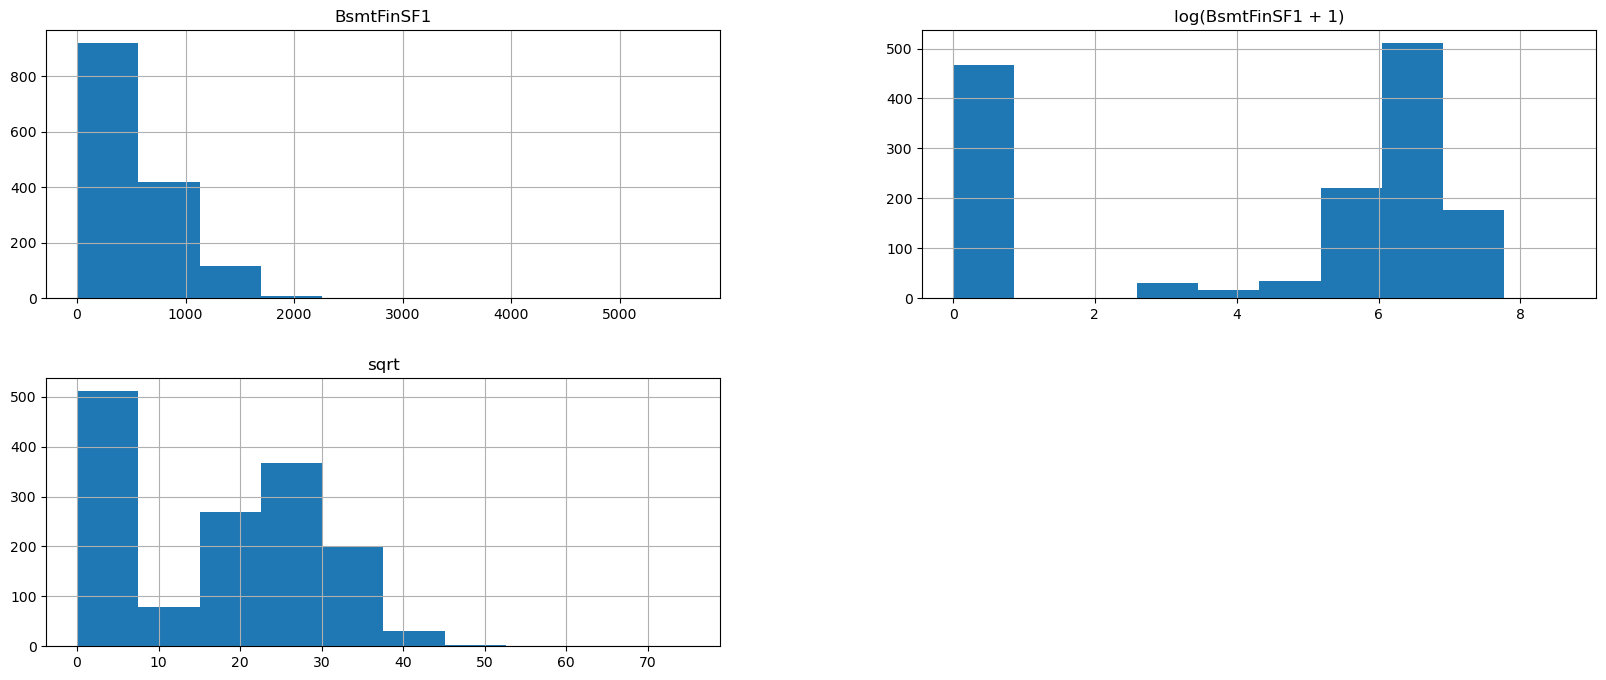

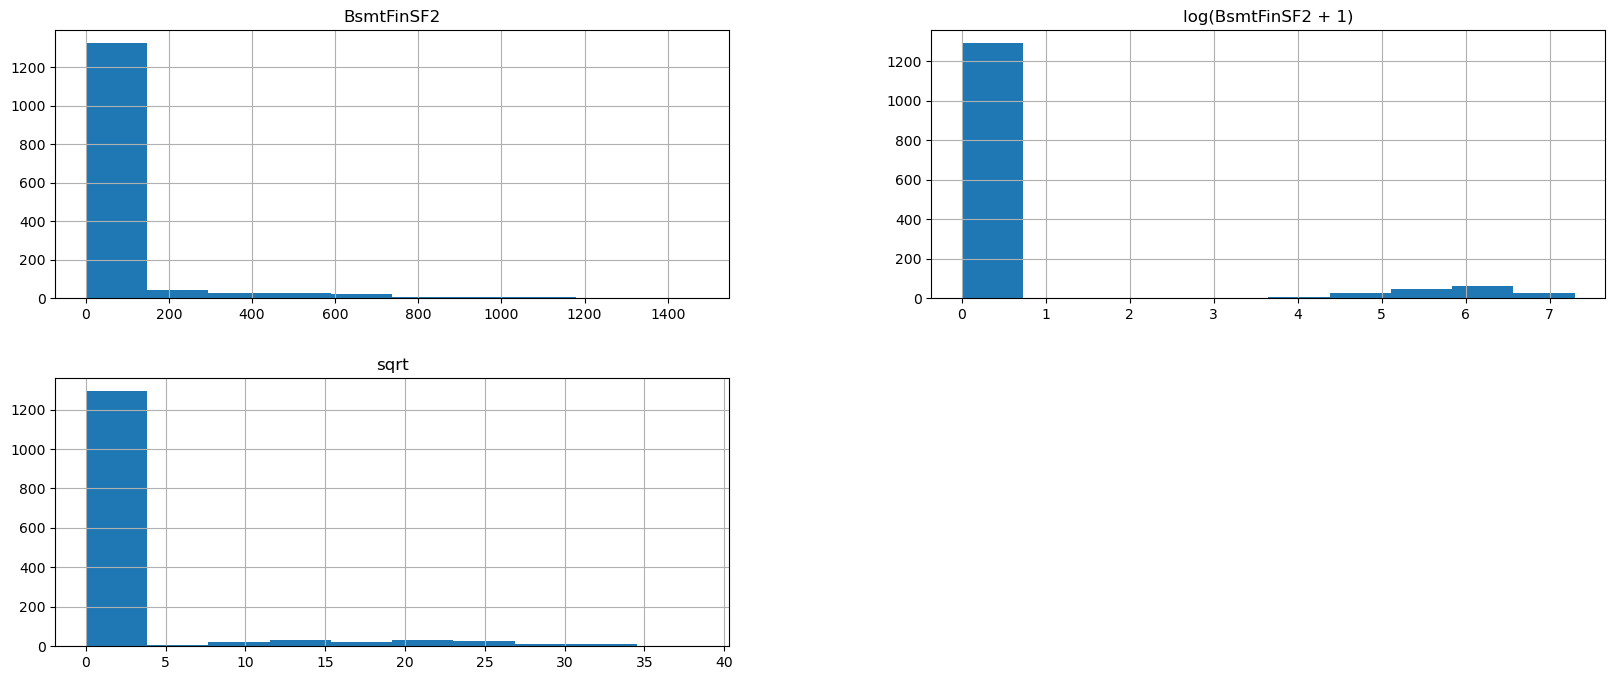

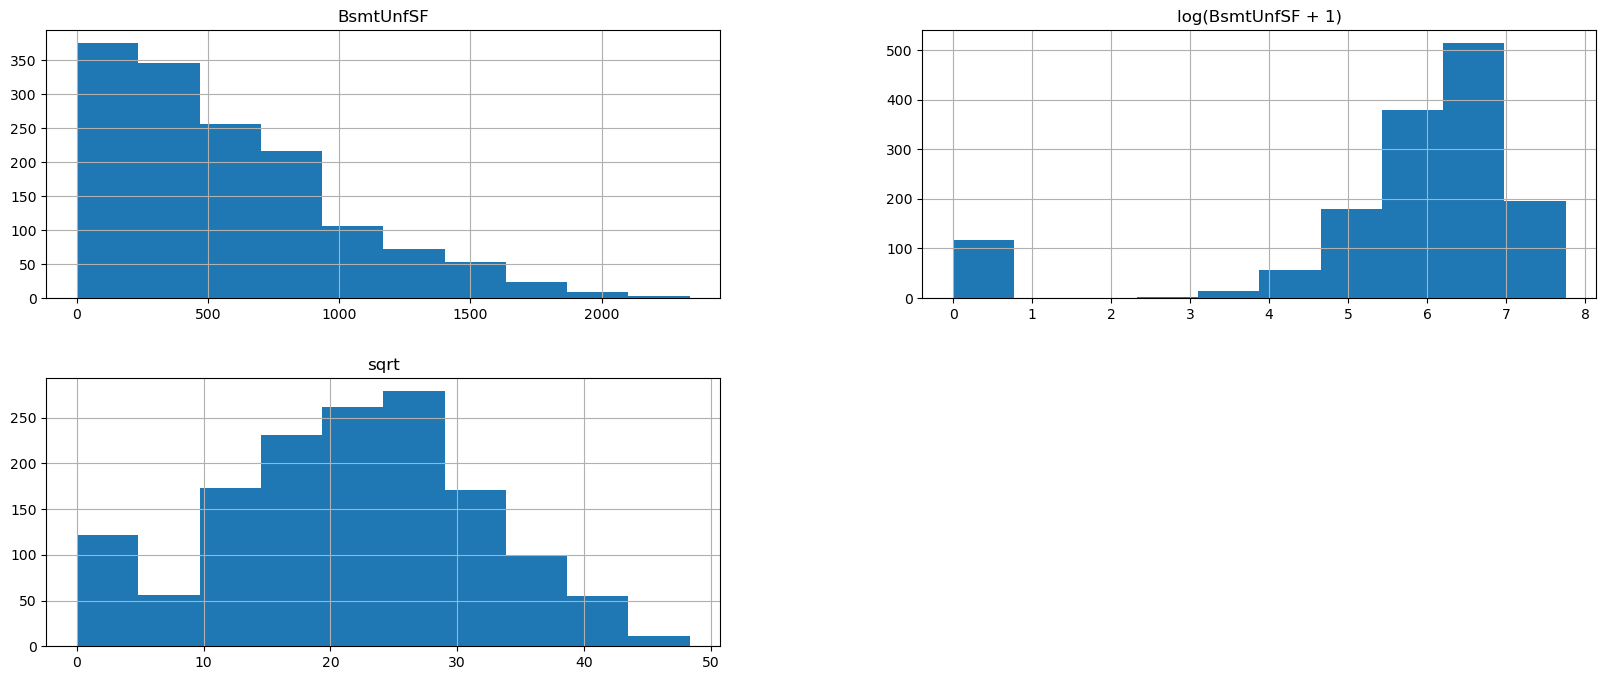

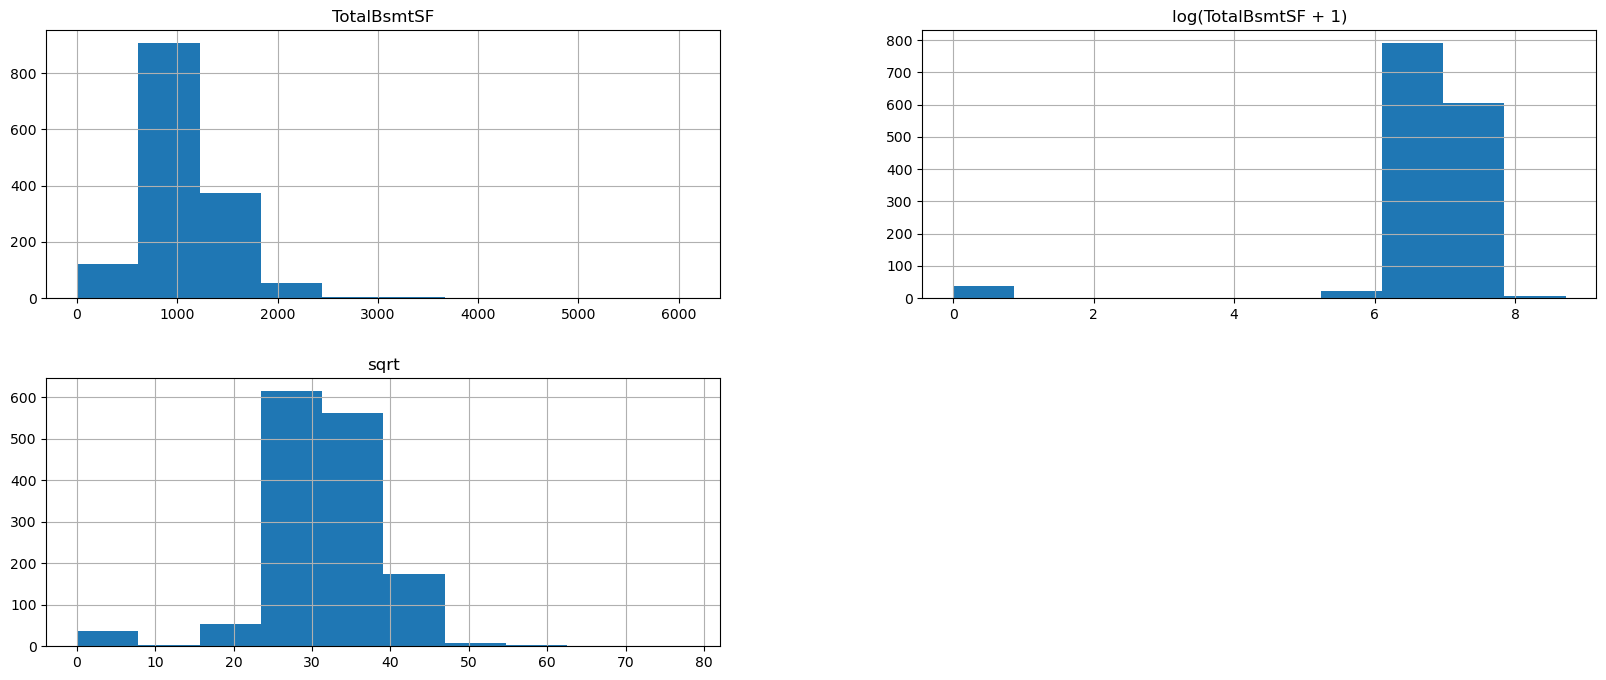

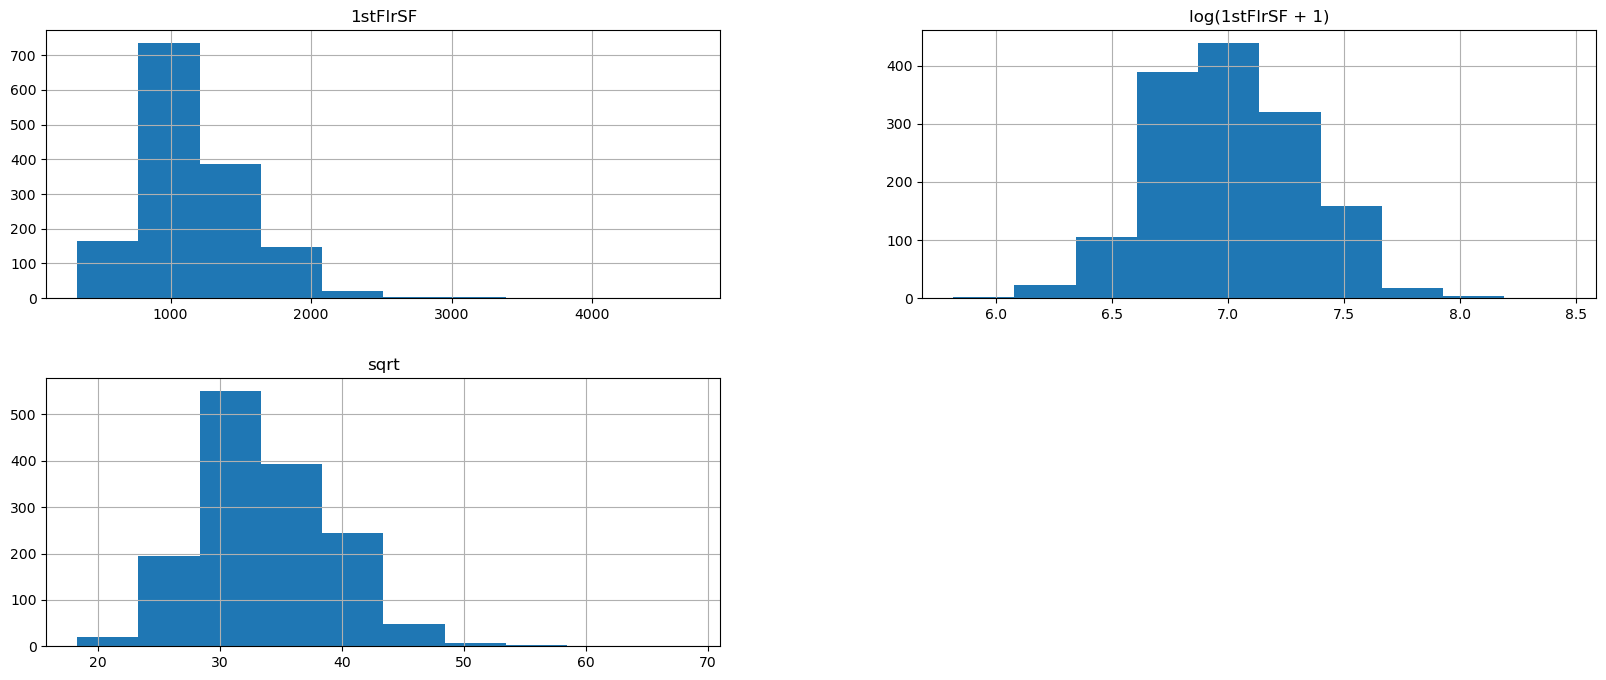

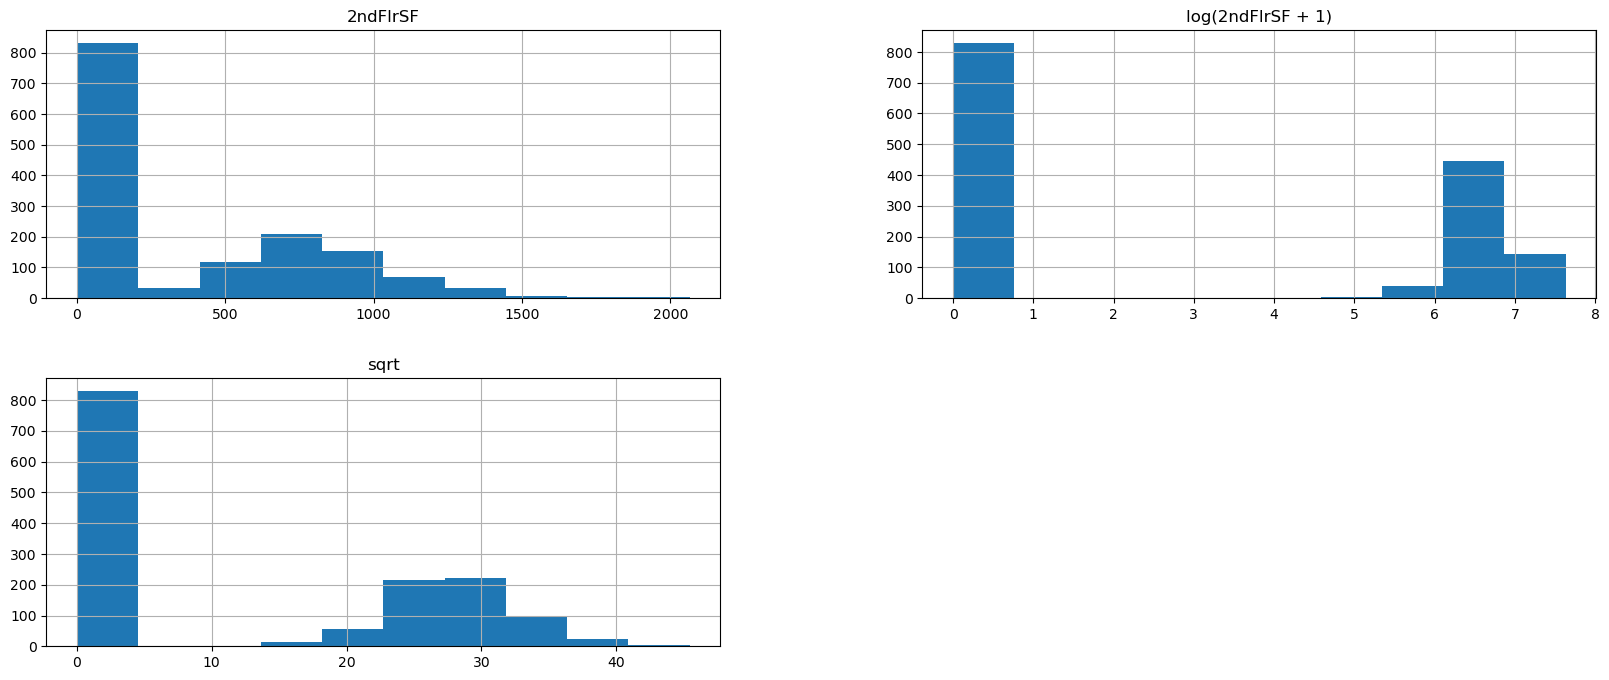

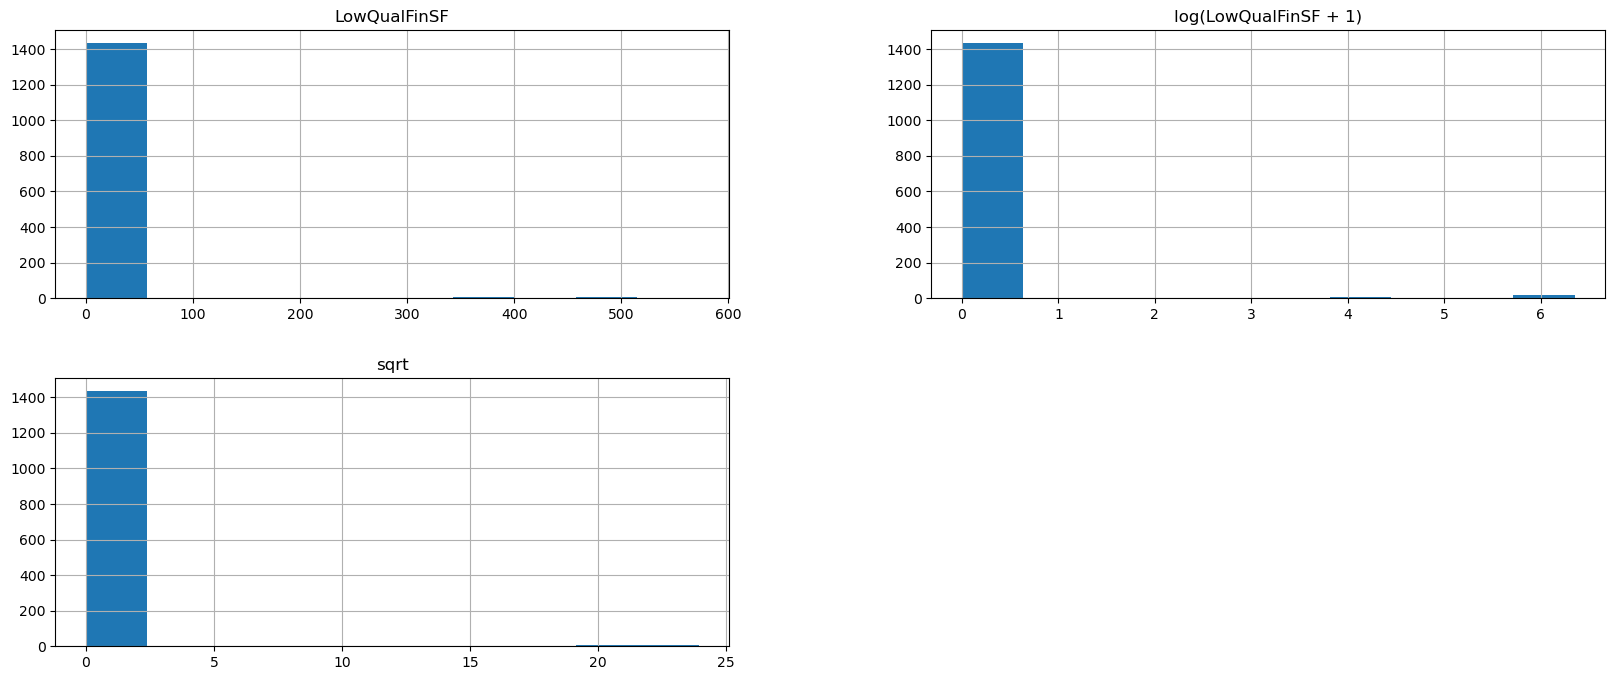

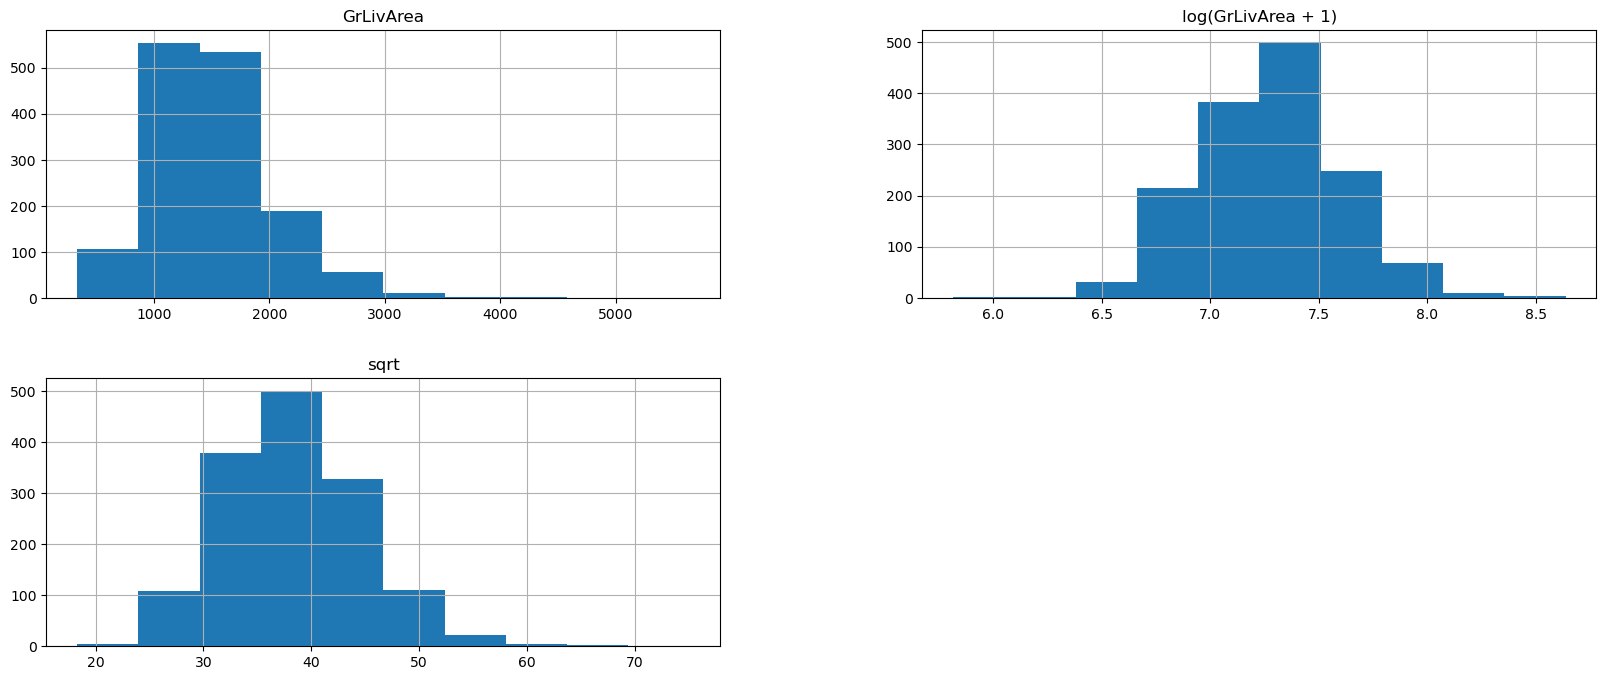

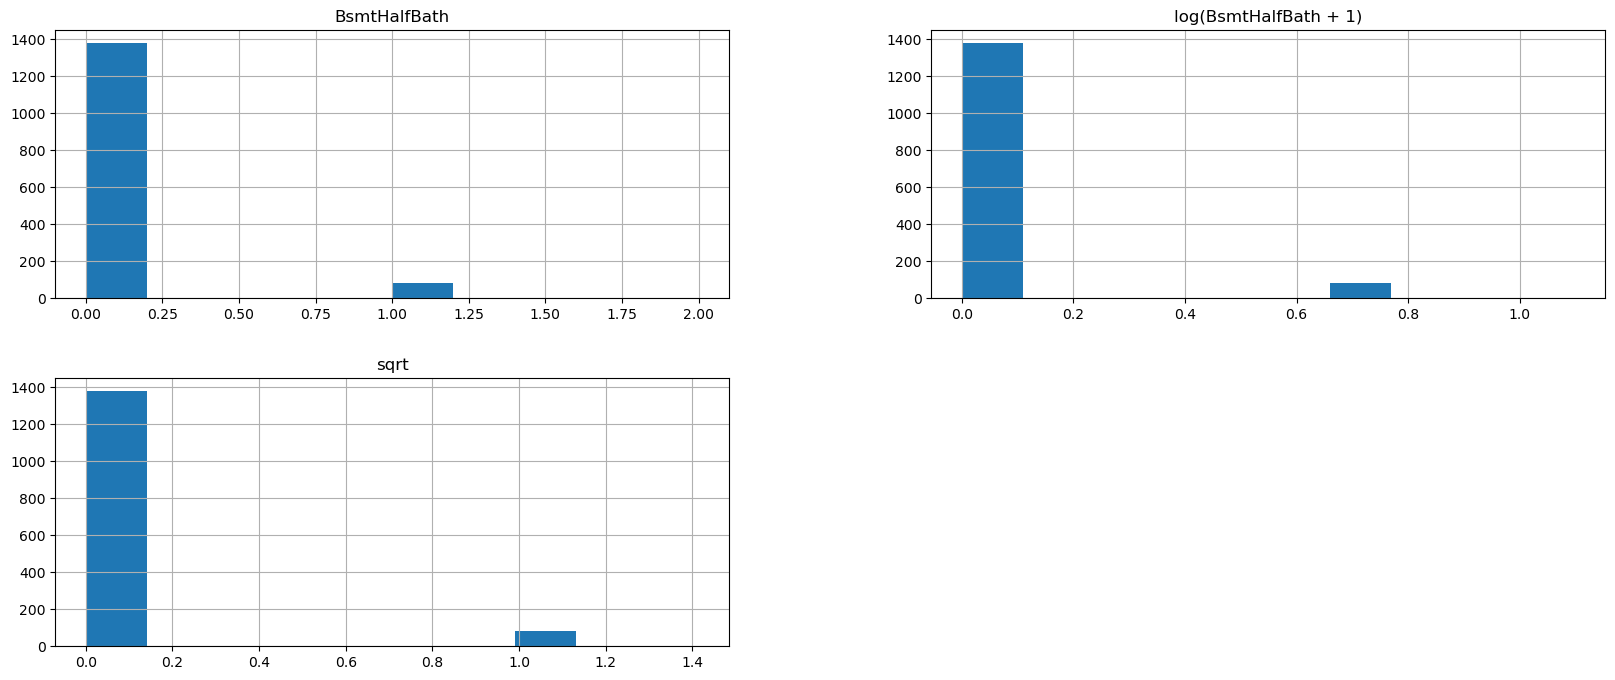

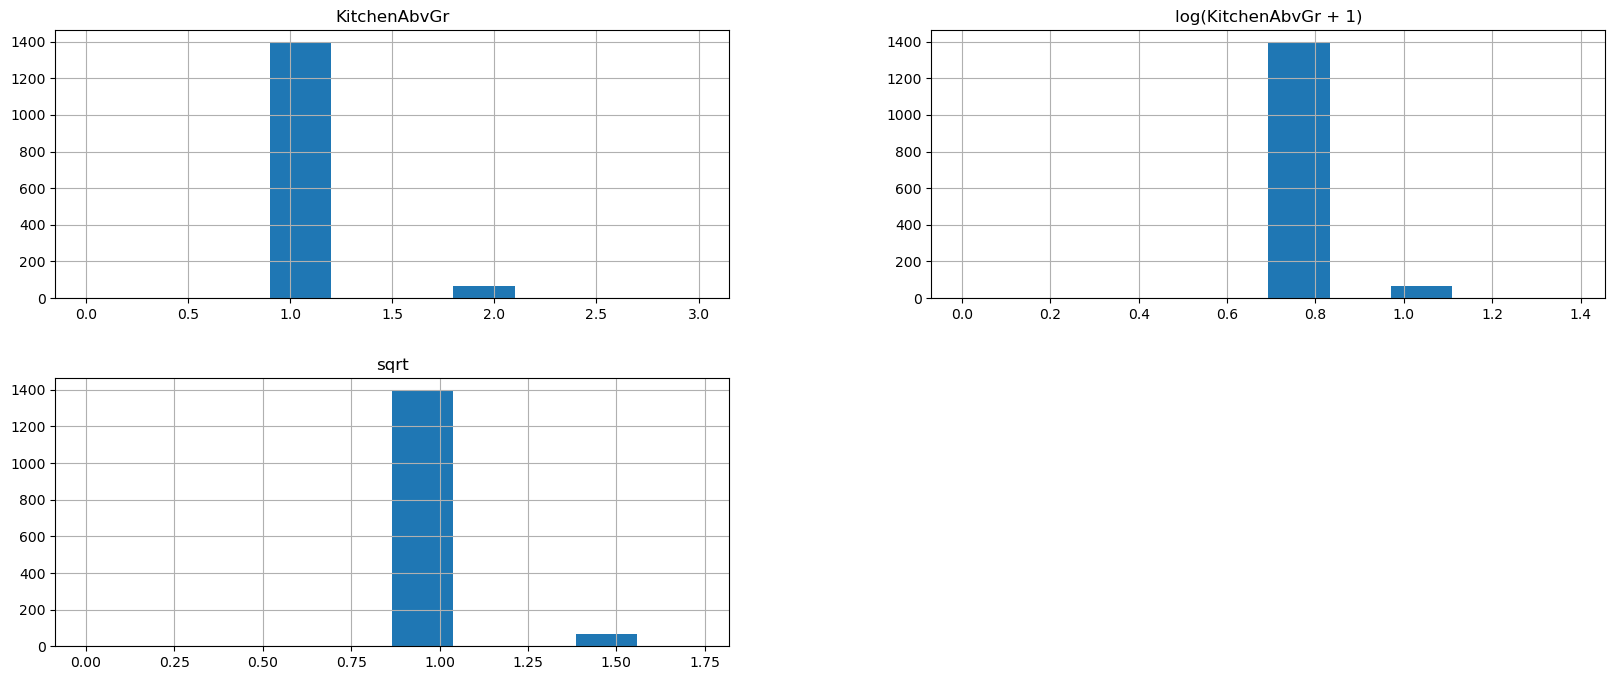

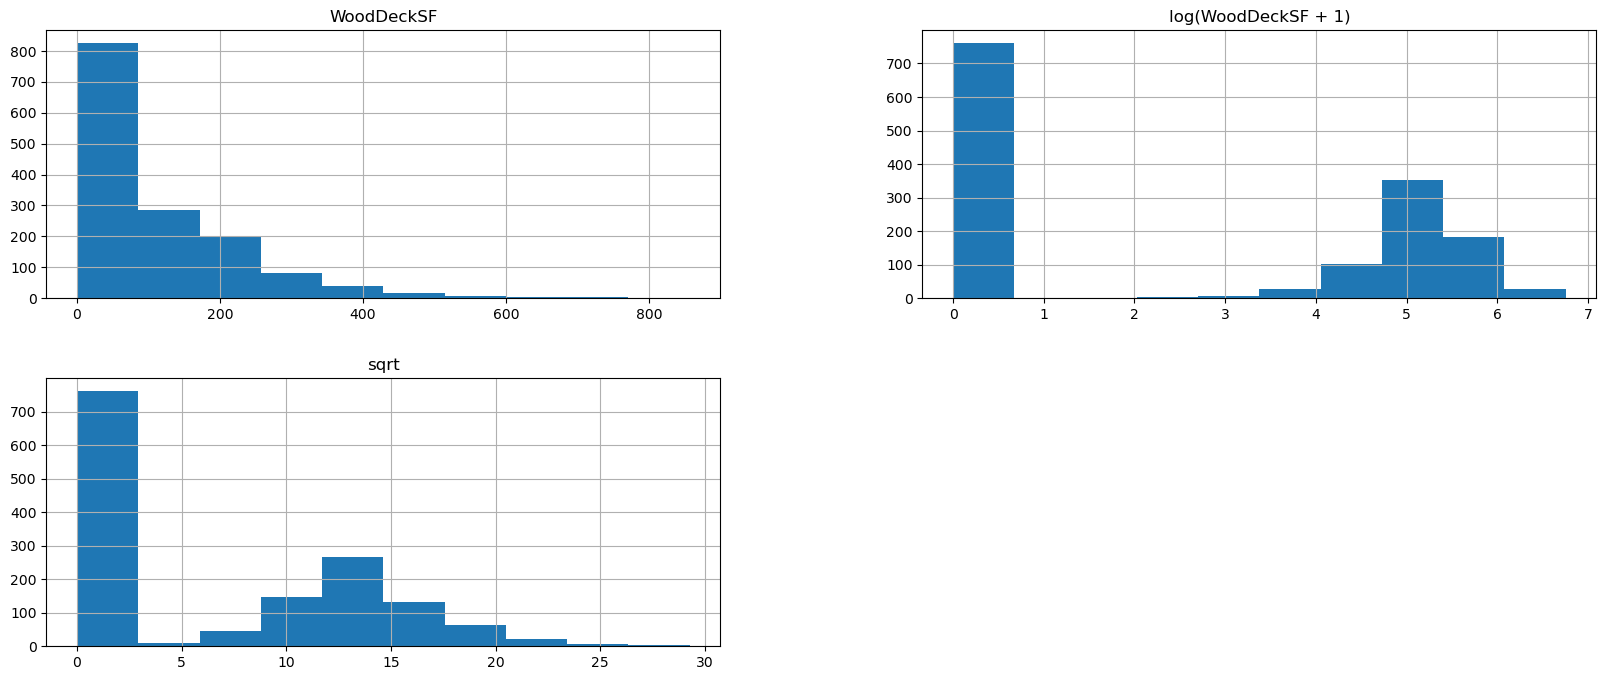

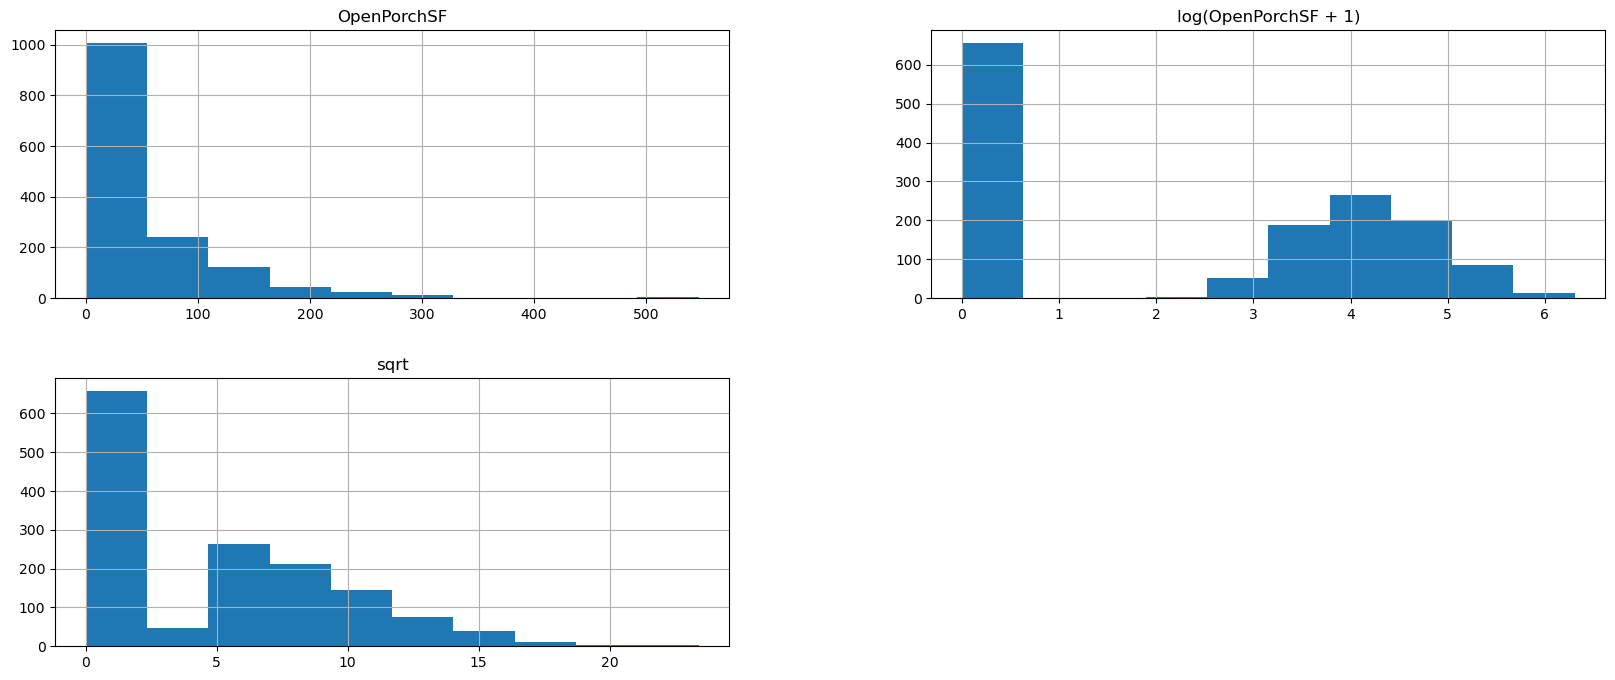

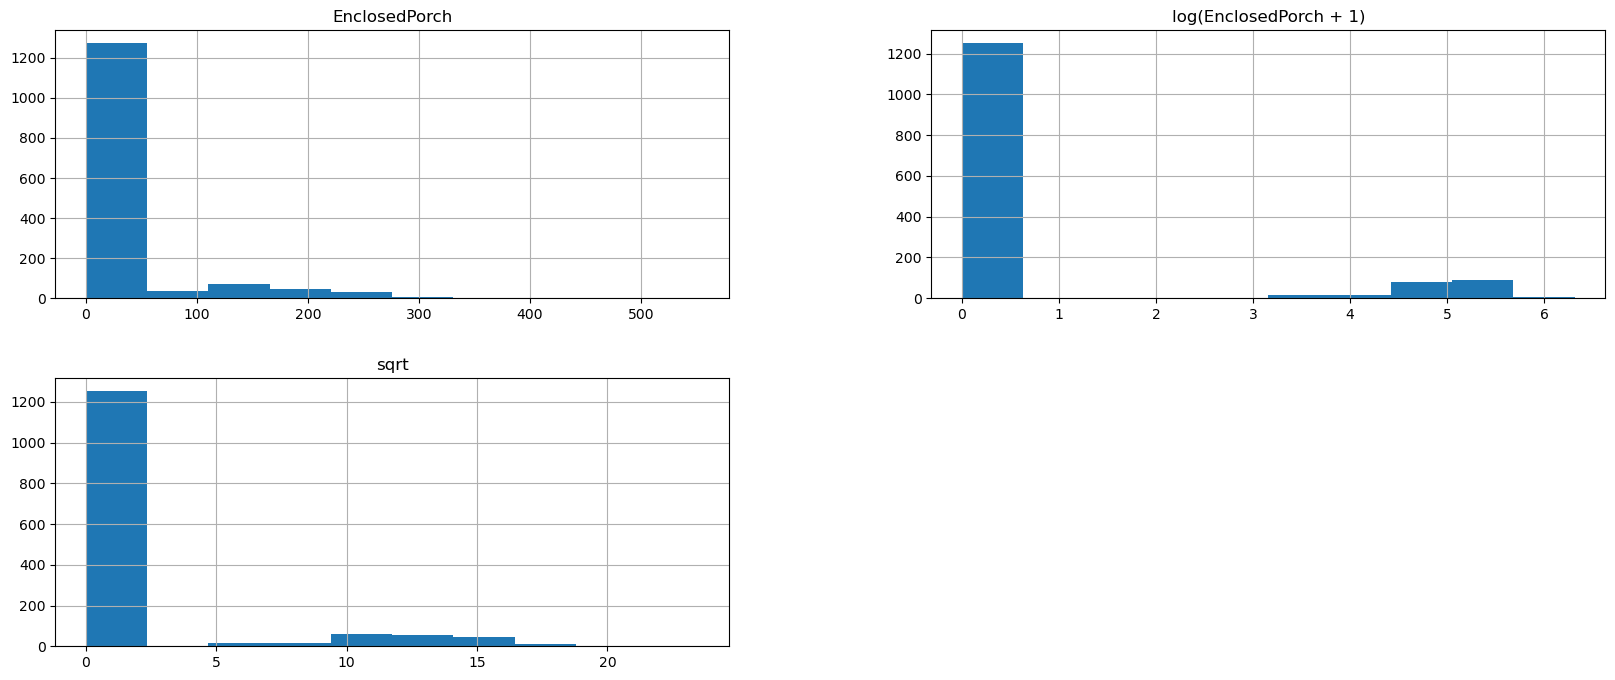

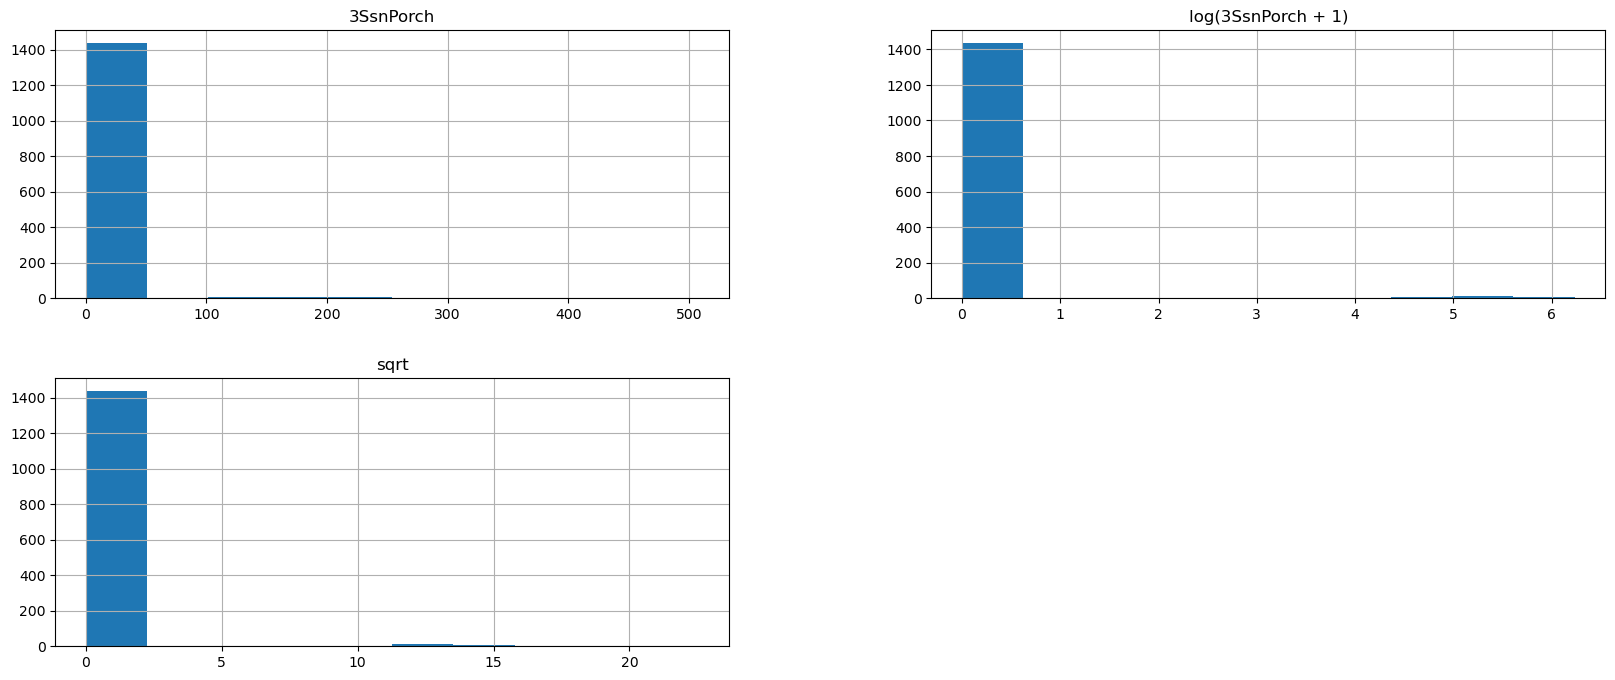

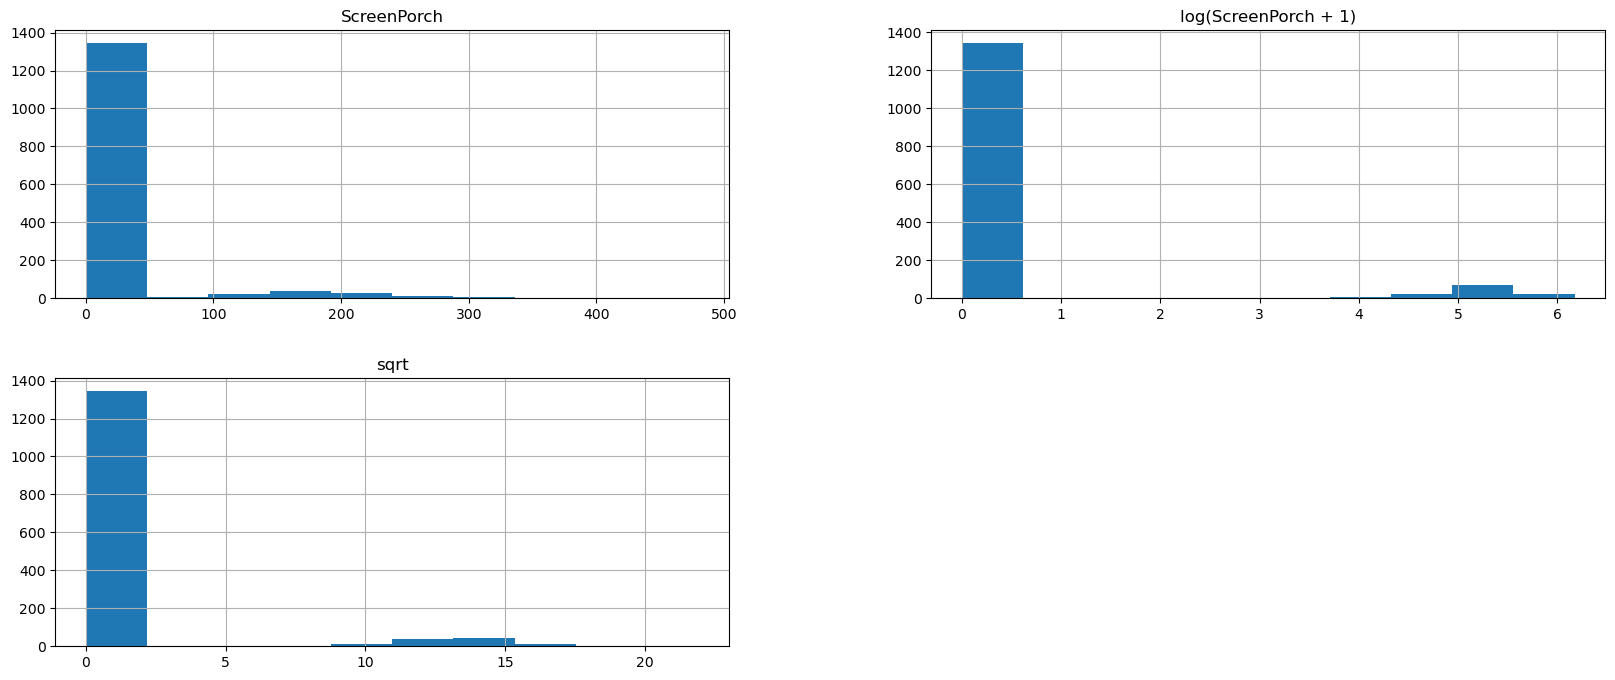

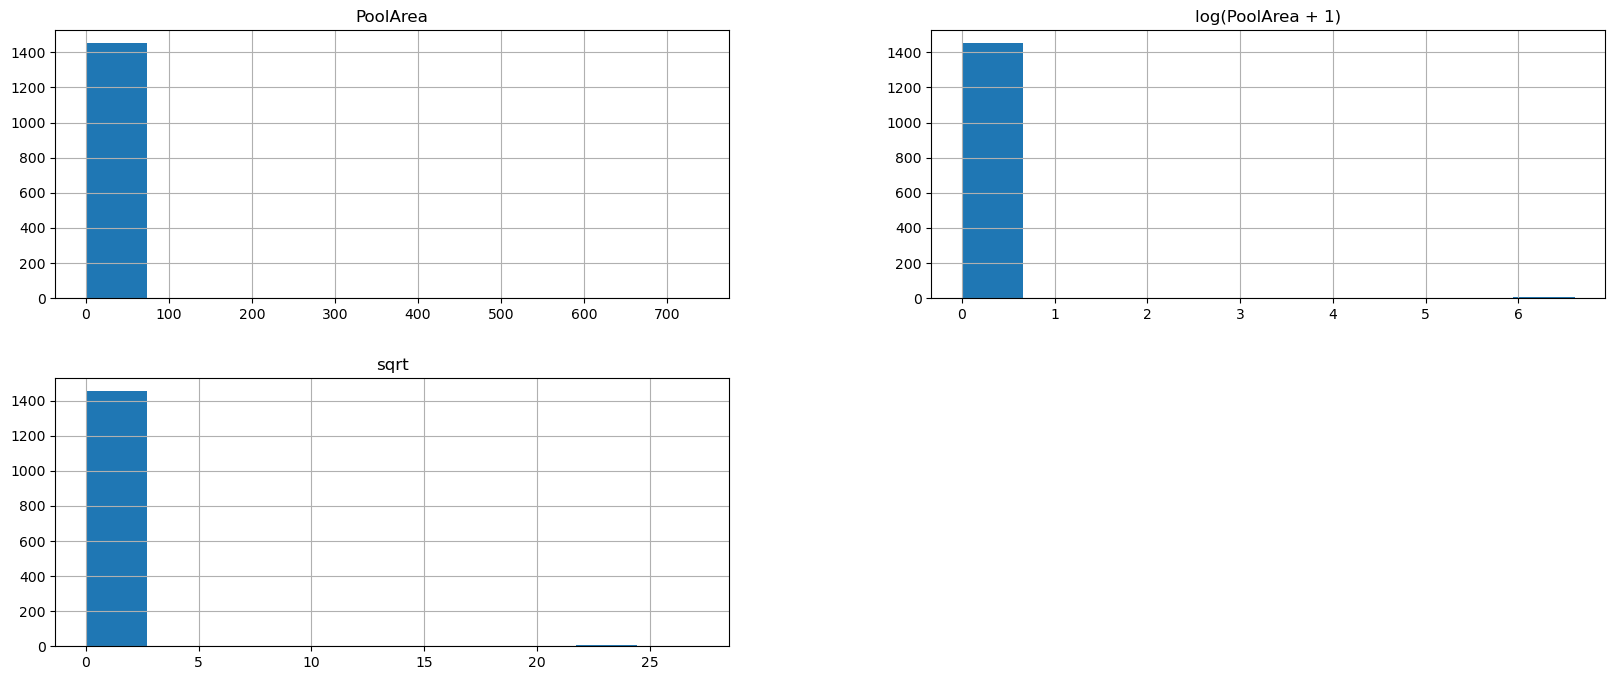

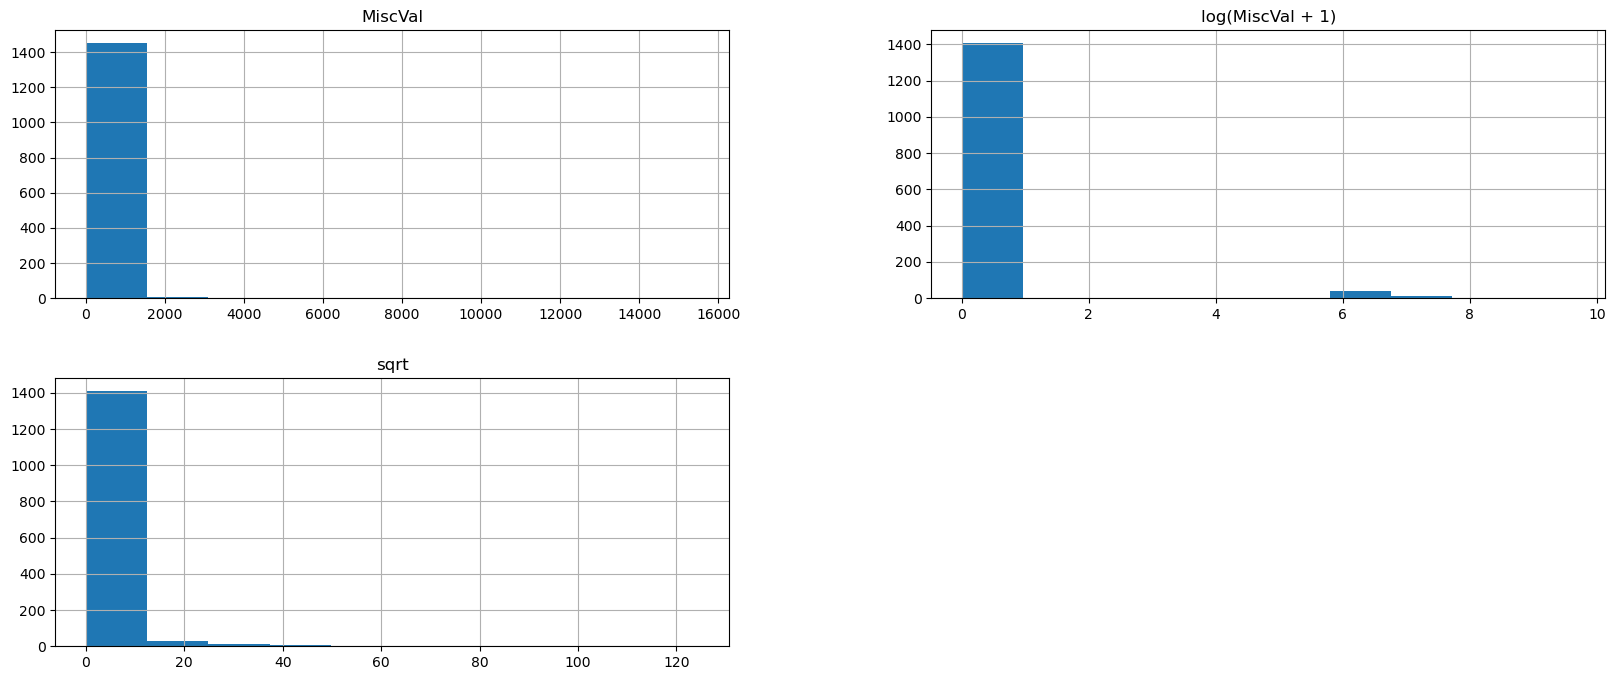

In [12]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
#편향성이 0.75이상이면 기억
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

log_idx = []
sqrt_idx = []
for i in skewed_feats:
    matplotlib.rcParams['figure.figsize'] = (20.0, 8.0)
    prices = pd.DataFrame({ i:all_data[i], "log(" + i + " + 1)":np.log1p(all_data[i]), "sqrt":np.sqrt(all_data[i])})
    a = pd.DataFrame(np.log1p(all_data[i])).apply(lambda x: skew(x.dropna()))
    b = pd.DataFrame(np.sqrt(all_data[i])).apply(lambda x: skew(x.dropna())) 
    
    prices.hist()

#해당 그림을 통해
#데이터 정규화를 log(x+1) or sqrt 로 진행(더 편향성이 적은 쪽으로 선택)


In [13]:
#가격(label)의 편향성이 심해, log를 통해 바꿔주는 코드.
train["SalePrice"] = np.log1p(train["SalePrice"])
test["SalePrice"] = np.log1p(test["SalePrice"])

#숫자값에 대한 feature의 인덱스를 받은 후, 이의 편향성을 고려하여 log로 편향성을 제거해주는 모습.
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
#편향성이 0.75이상이면 기억
skewed_feats = skewed_feats[abs(skewed_feats) > 0.75]
skewed_feats = skewed_feats.index

#abs로 0에 가까울수록 대칭적인 거임
#Log 함수를 통해 편향성을 완화하는 코드
a = pd.DataFrame(np.log1p(all_data[skewed_feats])).apply(lambda x: skew(x.dropna()))
b = pd.DataFrame(np.sqrt(all_data[skewed_feats])).apply(lambda x: skew(x.dropna()))
for i in skewed_feats:
    log_val = abs(pd.DataFrame(np.log1p(all_data[i])).apply(lambda x: skew(x.dropna()))).values
    sqrt_val = abs(pd.DataFrame(np.sqrt(all_data[i])).apply(lambda x: skew(x.dropna()))).values
    if log_val < sqrt_val:
        all_data[i] = np.log1p(all_data[i])
    else:
        all_data[i] = np.sqrt(all_data[i])
    
print(all_data[skewed_feats].apply(lambda x: skew(x.dropna())))

MSSubClass        0.248741
LotFrontage       0.378914
LotArea          -0.137263
MasVnrArea        0.493907
BsmtFinSF1       -0.029915
BsmtFinSF2        2.521100
BsmtUnfSF        -0.246253
TotalBsmtSF      -1.273228
1stFlrSF          0.080032
2ndFlrSF          0.289346
LowQualFinSF      7.452650
GrLivArea        -0.006134
BsmtHalfBath      3.889992
KitchenAbvGr      3.102306
WoodDeckSF        0.153379
OpenPorchSF      -0.023373
EnclosedPorch     2.110104
3SsnPorch         7.727026
ScreenPorch       3.147171
PoolArea         14.348342
MiscVal           5.165390
dtype: float64


In [14]:
# Get a Pd.Series consisting of all the string categoricals
one_hot_encode_cols = all_data.dtypes[all_data.dtypes == object]  # filtering by string categoricals
one_hot_encode_cols = one_hot_encode_cols.index.tolist()  # list of categorical fields
#원핫인코딩하는 코드
# Here we see another way of one-hot-encoding:
# Encode these columns as categoricals so one hot encoding works on split data (if desired)
for col in one_hot_encode_cols:
    all_data[col] = pd.Categorical(all_data[col])
    
# Do the one hot encoding
all_data = pd.get_dummies(all_data, columns=one_hot_encode_cols)

print(all_data.shape)
print(all_data.head)

(1460, 288)
<bound method NDFrame.head of       MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
135     3.044522     8.944272  9.249657            7            6       1970   
1452    5.198497     5.916080  8.209580            5            5       2005   
762     4.110874     8.485281  9.064274            7            5       2009   
932     3.044522     9.165151  9.364862            9            5       2006   
435     4.110874     6.557439  9.275004            7            6       1996   
...          ...          ...       ...          ...          ...        ...   
331     3.044522     8.366600  9.009081            5            6       1958   
323     3.044522     7.000000  8.669227            3            8       1955   
650     4.110874     8.062258  9.002824            7            6       2007   
439     3.931826     8.185353  9.421816            6            8       1920   
798     4.110874    10.198039  9.511851            9            5       2008  

In [15]:
#결측치 처리
all_data = all_data.fillna(all_data.mean())

In [16]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.SalePrice
y_test = test.SalePrice
print(X_train.shape)
print(X_test.shape)

(1022, 288)
(438, 288)


전처리 과정을 거친 후, Linear 모델을 학습시키는 부분

In [17]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

In [18]:
linearRegression_model_biasprocessing = LinearRegression().fit(X_train, y_train)
linearRegression_rmse = rmse(y_test, linearRegression_model_biasprocessing.predict(X_test))
print(linearRegression_rmse)

0.5962141746455106


<AxesSubplot:xlabel='preds', ylabel='actual'>

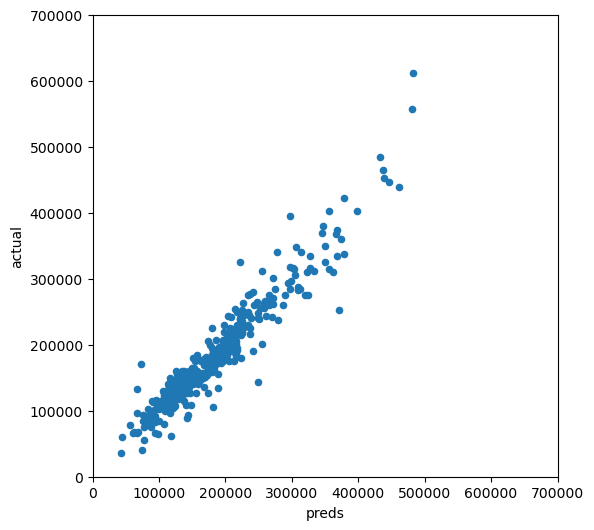

In [19]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

two = pd.DataFrame({"preds": np.expm1(linearRegression_model_biasprocessing.predict(X_test)), "true":np.expm1(y_test)})
two["actual"] = two["true"]
two.plot(x = "preds", y = "actual",kind = "scatter", xlim = [0, 7*1e5], ylim = [0, 7*1e5])

### 데이터 전처리 유무에 따른 학습결과 비교하는 그림


데이터 셋이 다르고, 전처리를 진행했기 때문에 객관적인 평가는 어렵지만 그림으로 확인해보면 전처리를 진행한 모델은
예측이 크게 실패한 데이터가 없음. 반면 기존 모델에서는 예측이 크게 실패한 데이터가 존재함.(왼쪽 상단) 나머지는 상당히 유사하기 때문에 앞으로 편향도를 보정한 데이터로 진행.
반면, 과제13을 진행한, 차와 관련된 데이터는 전처리결과가 오히려 정확도를 낮추는 일이 발생함. 해당 데이터는 전체적으로 편향도가 극심한 데이터가 거의 없었으며, 여기서 사용하는 데이터는 
BsmtFinsf1, MasVnrArea, LotArea 등 한 가격으로 쏠려있는 데이터가 존재하기에 그럴 것이라 추측함.

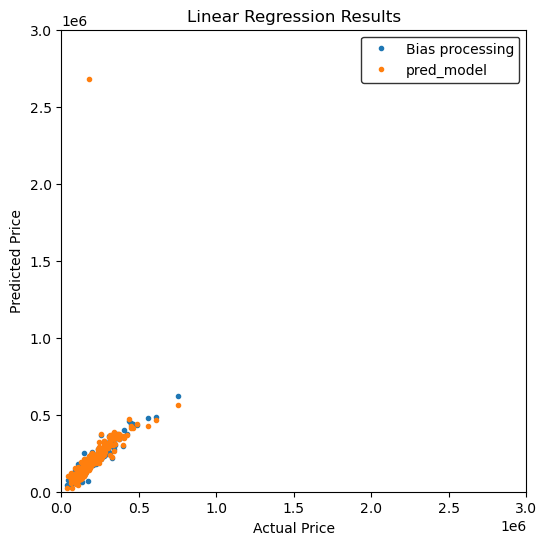

In [20]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.plot(np.expm1(y_test), np.expm1(linearRegression_model_biasprocessing.predict(X_test)), 
             marker='o', ls='', ms=3.0, label="Bias processing")
ax.plot(test_y, linearRegression_model.predict(test_beta), 
             marker='o', ls='', ms=3.0, label="pred_model")

leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.0)
ax.set_xlim([0, 3*1e6])
ax.set_ylim([0, 3*1e6])
ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       title='Linear Regression Results');


또한, 아래의 그림을 보면 데이터 전처리가 없는 모델은 상대적으로 작은 차수의 값에 더 영향을 많이 받는 것을 확인할 수 있었습니다.

(288,)


[Text(0, 0.5, 'pred model')]

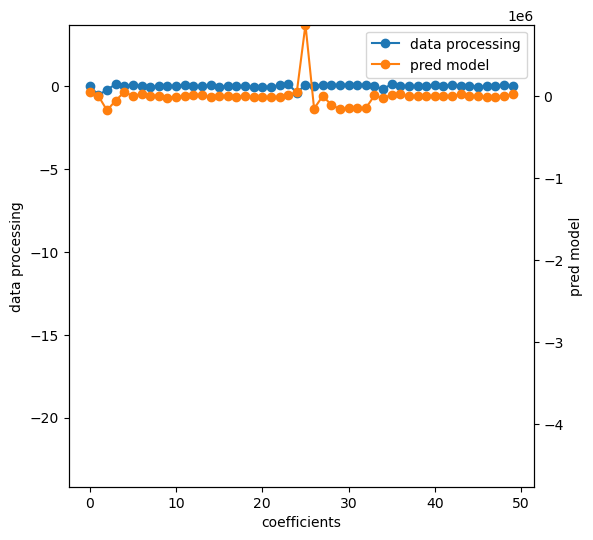

In [21]:
colors = sns.color_palette()
print(linearRegression_model_biasprocessing.coef_.ravel().shape)
# Setup the dual y-axes
ax1 = plt.axes()
ax2 = ax1.twinx()
ax1.plot(linearRegression_model_biasprocessing.coef_.ravel()[100:150], 
         color=colors[0], marker='o', label='data processing')

# Plot the regularization data sets
ax2.plot(linearRegression_model.coef_.ravel()[100:150], 
         color=colors[1], marker='o', label='pred model')

ax1.set_ylim(linearRegression_model_biasprocessing.coef_.ravel().min(), linearRegression_model_biasprocessing.coef_.ravel().max())
ax2.set_ylim(linearRegression_model.coef_.ravel().min(), linearRegression_model.coef_.ravel().max())
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2)

ax1.set(xlabel='coefficients',ylabel='data processing')
ax2.set(ylabel='pred model')

### Lasso 모델

In [22]:
alphas = [1, 0.5, 0.1, 0.01, 0.005 ,0.001, 0.0005,0.0001]
model_lasso = LassoCV(alphas=alphas,
                  max_iter=5e4,
                  cv=3).fit(X_train, y_train)

In [23]:
lassoCV_rmse = rmse(y_test,model_lasso.predict(X_test))
print(lassoCV_rmse)

0.12457508517681189


In [24]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

lasso 모델이 82개의 feature만 선택하고 206개의 feature를 제거한 모습. intel ML과 팀의 다른 데이터를 통해 lasso를 진행했을 때, 하위 25%정도의 Feature만 제거한 경우와 상반됨 -> lasso 는 집가격예측 데이터 중에 모델의 학습에 좋은 데이터는 많이 없다고 추측함.

In [25]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 82 variables and eliminated the other 206 variables


In [26]:
imp_coef = pd.concat([coef.sort_values().head(20),
                     coef.sort_values().tail(20)])

계수들을 양수에서 20개, 음수에서 20개의 큰 값으로 보여주는 모습
GRootmatl_Clytile(지붕재료 관련) 와 같이 생각보다 별 의미없어보이는 데이텉의 영향력이 큰 것을 확인할 수 있다. 흔한 통념으로 - ex) 역세권이면 집값이 높으니, 역세권 데이터를 제곱하는 등. - 와 같이
데이터전처리를 하는 것보단. 상관계수나, 모델링을 해보고 영향도를 보고 데이터를 전치리하는 것이 좋다고 느낄 수 있었습니다.

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

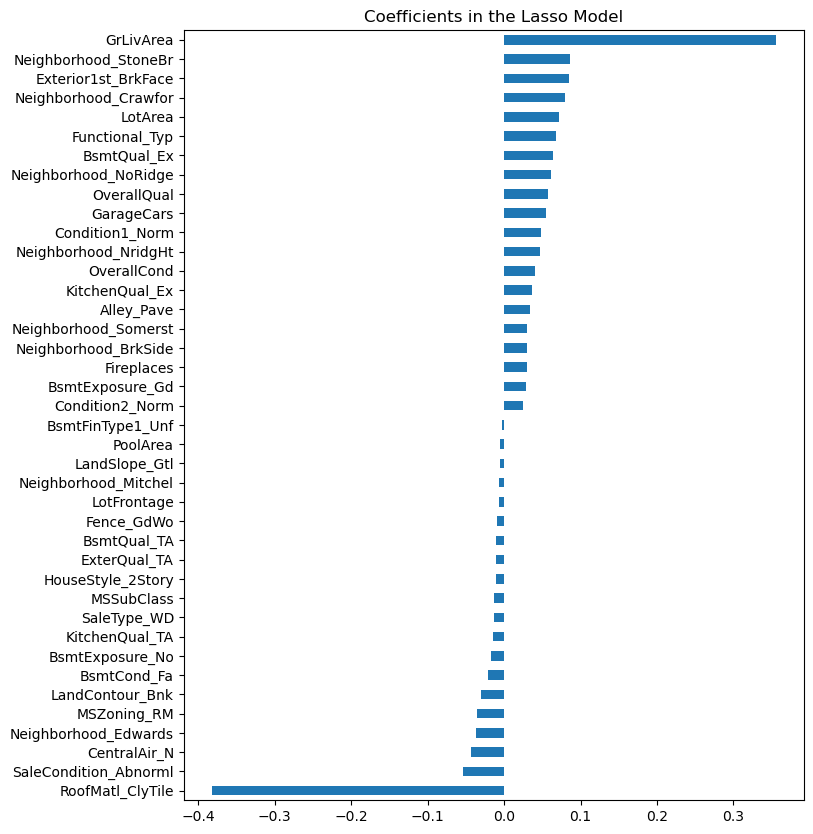

In [27]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

<AxesSubplot:xlabel='preds', ylabel='actual'>

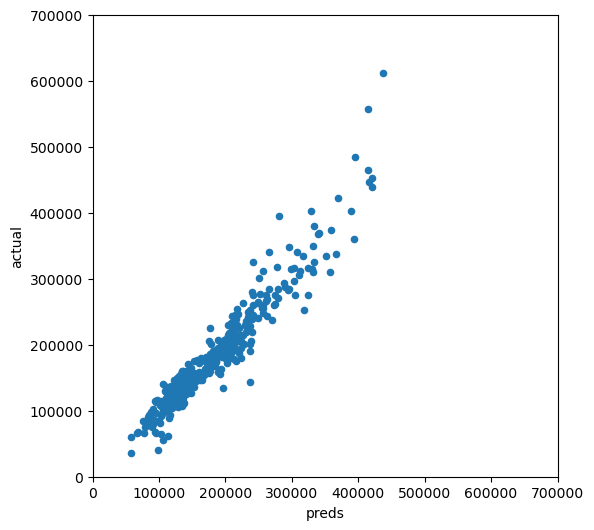

In [28]:
#let's look at the residuals as well:

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds": np.expm1(model_lasso.predict(X_test)), "true":np.expm1(y_test)})
preds["actual"] = preds["true"]
preds.plot(x = "preds", y = "actual",kind = "scatter", xlim = [0, 7*1e5], ylim = [0, 7*1e5])

### lasso / linear 비교하는 부분

같은 데이터로 진행했기에, 객관적인 평가가 가능한 두 모델은 RMSE를 보면 확실히 lasso 의 모델이 더 정확한 것을 확인할 수 있음.
그림으로 보면, 300000이상은 유사하지만, 300000이하의 데이터에서 lasso는 더 가운데로 응집해 있는 모습을 보임 -> 학습이 비교적 잘 되었음을 볼 수 있음.

In [29]:
rmse_vals = [linearRegression_rmse, lassoCV_rmse]

labels = ['Linear', 'Lasso']

rmse_df = pd.Series(rmse_vals, index=labels).to_frame()
rmse_df.rename(columns={0: 'RMSE'}, inplace=1)
print(rmse_df)

            RMSE
Linear  0.596214
Lasso   0.124575


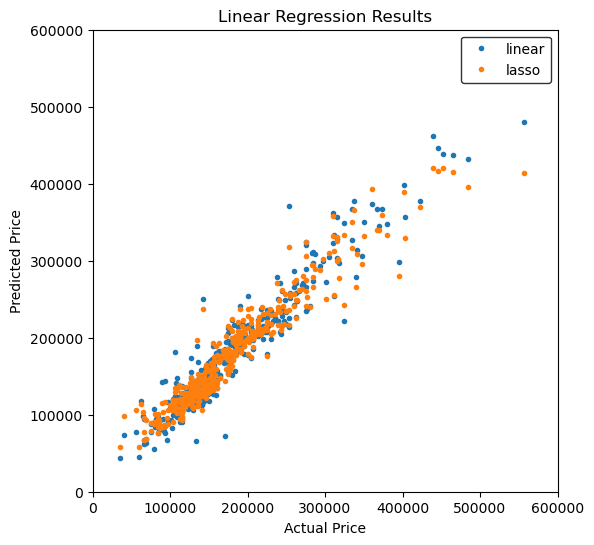

In [30]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.plot(np.expm1(y_test), np.expm1(linearRegression_model_biasprocessing.predict(X_test)), 
             marker='o', ls='', ms=3.0, label="linear")
ax.plot(np.expm1(y_test), np.expm1(model_lasso.predict(X_test)), 
             marker='o', ls='', ms=3.0, label="lasso")

leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.0)
ax.set_xlim([0, 6*1e5])
ax.set_ylim([0, 6*1e5])
ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       title='Linear Regression Results');

### SGD 방법 채택하는 부분

SGD와 같은 경우 경사하강법을 사용하기에, 모델을 적합하게 맞추지 못하고 발산하는 모습을 보여준다.

In [31]:
model_parameters_dict = {
    'Linear': {'penalty': 'none'},
    'Lasso': {'penalty': 'l2',
           'alpha': model_lasso.alpha_},
}
new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)
    SGD.fit(X_train, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test))

rmse_df['RMSE-SGD'] = pd.Series(new_rmses)
rmse_dflpha=model_lasso.alpha_
print(rmse_df)

            RMSE      RMSE-SGD
Linear  0.596214  2.508123e+15
Lasso   0.124575  1.063694e+16


학습속도를 조정하여, 발산을 방지해주니, Rmse가 급격히 낮아지는 것을 확인할 수 있다.

In [32]:
new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(eta0=1e-7,**parameters)
    SGD.fit(X_train, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test))

rmse_df['RMSE-SGD'] = pd.Series(new_rmses)
rmse_dflpha=model_lasso.alpha_
print(rmse_df)

            RMSE  RMSE-SGD
Linear  0.596214  0.285137
Lasso   0.124575  0.284816


스케일링을 해준 모습이다. StandardScaler()와는 전혀맞지 않는 모습이다. Learning rate 를 조정해주면 그나마, 괜찮아지는 모습이다. intel ML에서는 standard로 진행했을 때, 오히려 Minmax 정규화보다 좋았던 경우가 많다. 아마 해당 데이터와 모델에서 표준정규화보단, Minmax가 더 잘 맞는 것 같다. ex) Ch4. 에서 데이터 전처리(원핫인코딩, 편향도 보정)와 데이터의 개수, 특징의 개수 또한 비슷하지만, standard로 바꿔서 실험했을 때, 오히려 더 좋아진 것을 확인했다.

In [33]:
#스케일링을 하니 rmse(가장 오른쪽)이 좀 줄어드는 모양.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)
    SGD.fit(X_train_scaled, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test_scaled))

rmse_df['RMSE-SGD-stdscaled'] = pd.Series(new_rmses)
rmse_df

,RMSE,RMSE-SGD,RMSE-SGD-stdscaled
Linear,0.596214,0.285137,229.692436
Lasso,0.124575,0.284816,185.471537


In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(eta0=1e-7, **parameters)
    SGD.fit(X_train_scaled, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test_scaled))

rmse_df['stdscaled+학습율조정'] = pd.Series(new_rmses)
rmse_df

,RMSE,RMSE-SGD,RMSE-SGD-stdscaled,stdscaled+학습율조정
Linear,0.596214,0.285137,229.692436,12.013974
Lasso,0.124575,0.284816,185.471537,12.013973


minmax 정규화를 진행하니, 확실히 SGD 모델중에 가장 우수한 정확도를 보인다. SGD 모델이 스케일러에 민감하다는 것을 또 다시 확인할 수 있는 모습이고, 
선형 모델과 같은 경우 SGD의 경사하강법이 더 좋은 성능을 보이는 것을 확인할 수 있다.

,RMSE,RMSE-SGD,RMSE-SGD-stdscaled,stdscaled+학습율조정,RMSE-SGD-scaled
Linear,0.596214,0.285137,229.692436,12.013974,0.230250
Lasso,0.124575,0.284816,185.471537,12.013973,0.226884


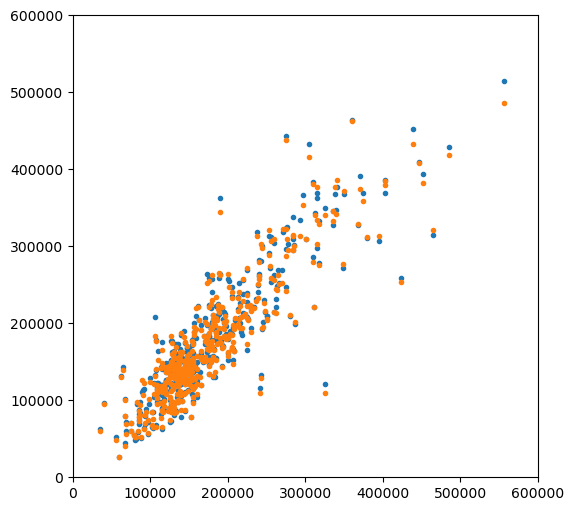

In [35]:
#스케일링을 하니 rmse(가장 오른쪽)이 좀 줄어드는 모양.
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
f = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.set_xlim([0, 6*1e5])
ax.set_ylim([0, 6*1e5])
new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)
    SGD.fit(X_train_scaled, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test_scaled))
    #let's look at the residuals as well:
    ax.plot(np.expm1(y_test), np.expm1(SGD.predict(X_test_scaled)), 
             marker='o', ls='', ms=3.0, label=modellabel)
    

rmse_df['RMSE-SGD-scaled'] = pd.Series(new_rmses)
rmse_df


### 결론




- 데이터 전처리를 유무에 따라서, 모델의 학습결과와 형성방법에 영향을 미치는 것을 확인할 수 있었다. 해당 데이터에서는 전처리를 거침으로, 확실히 크게 엇나가는 데이터가 없어지는 것을 목격했다.
편향도를 보정하는 방법으로는 sqrt 와 Log 등의 기본적인 방법이 있고, 어느 방법이 옳다기보단 데이터에 맞추어 사용하는 것이 중요하다는 것을 느꼈다.

- 해당 데이터에서는 lasso와 적합한 데이터라고 느꼈다. 데이터의 개수(약 1400)에 비해 feature(인코딩을 통해 약 300개)가 많았으며, 대부분 그렇게 좋지 못한 데이터였다(상관계수로 추측). 그렇기에 intel ML에서는 Lasso는 약 25%의 특징만 제거한 반면 해당 데이터에서는 60~70%의 특징을 제거했으며 Rmse 또한 가장 우수하게 나왔다.
--> 비교적 feature가 많고, 상관계수가 낮은 데이터들로 이뤄져있으면 Lasso가 효율적이라는 것을 다시 한번 확인할 수 있었다.

- SGD의 경사하강법을 이용하여 데이터를 학습시켰는데, 데이터의 양이 적다보니 지속적으로 발산이 일어났다. learning rate를 조정해주니 그나마 괜찮은 모습이었다. 또한 정규화의 방법에 따라서 차이가 극심한 것을 볼 수 있었다. intel ML과 비교했을 때, 해당 데이터는 minmax에 적합한 데이터였다. 정규화의 방법 또한, 무엇이 옳고 그름이 아닌 데이터에 맞게 사용한다는 것을 알 수 있었다.

-  위의 과정을 요약해보면, 데이터의 전처리를 통하면, 크게 엇나가는 데이터를 잡아내고 응집력이 생기며, 데이터의 수에 비해 feature가 많은 경우 lasso와 같이 쓸모있는 데이터만을 추려서 학습시키는 것이 정확도에 좋으며, SGD와 같은 경우 발산에 대비해 학습율을 조정해야 정확도가 높아진다는 추측을 할 수 있었습니다.

- 결론적으로, 데이터에 대한 수준 높은 분석과 전처리가 모델 성능에 큰 영향을 끼친다는 것을 알았습니다. 상관계수, 편향도 등을 먼저 체크하고 추론하여 데이터를 가공시키며. 어떤 모델이 항상 좋다기보단,  데이터에 맞게 모델을 설정해야(lasso, Linear, SGD 유무) 한다는 것을 알게 되었습니다.

